# Preprocessing the input files

In [100]:
import xarray as xr
import os

# Set working directory
base_path = "K:/CMS/Internal/Personal/Mona/Hurricane/Adjustment_Gallagher/STORM_Code/STORM-climate-change-main/STORM-climate-change-main"

# Variables to process
variables = ['psl', 'ts']

# Loop through both psl and ts
for var in variables:
    print(f"🔄 Processing {var}...")

    file_early = os.path.join(base_path, f"{var}_Amon_CNRM-CM6-1-HR_highres-future_r1i1p1f2_gr_201501-203912.nc")
    file_mid   = os.path.join(base_path, f"{var}_Amon_CNRM-CM6-1-HR_highres-future_r1i1p1f2_gr_204001-204912.nc")
    file_out   = os.path.join(base_path, f"{var}_Amon_CNRM-CM6-1-HR_highres-future_r1i1p1f2_gr_203401-204312.nc")

    # Load datasets
    ds_early = xr.open_dataset(file_early)
    ds_mid = xr.open_dataset(file_mid)

    # Select time slices
    ds_early_sel = ds_early.sel(time=slice("2034-01-01", "2039-12-31"))
    ds_mid_sel = ds_mid.sel(time=slice("2040-01-01", "2043-12-31"))

    # Combine along time dimension
    ds_combined = xr.concat([ds_early_sel, ds_mid_sel], dim="time")

    # Save to output NetCDF
    ds_combined.to_netcdf(file_out)

    print(f"✅ Saved merged dataset: {file_out}")



🔄 Processing psl...
✅ Saved merged dataset: K:/CMS/Internal/Personal/Mona/Hurricane/Adjustment_Gallagher/STORM_Code/STORM-climate-change-main/STORM-climate-change-main\psl_Amon_CNRM-CM6-1-HR_highres-future_r1i1p1f2_gr_203401-204312.nc
🔄 Processing ts...
✅ Saved merged dataset: K:/CMS/Internal/Personal/Mona/Hurricane/Adjustment_Gallagher/STORM_Code/STORM-climate-change-main/STORM-climate-change-main\ts_Amon_CNRM-CM6-1-HR_highres-future_r1i1p1f2_gr_203401-204312.nc


# Step1A_Calculate_monthly_means

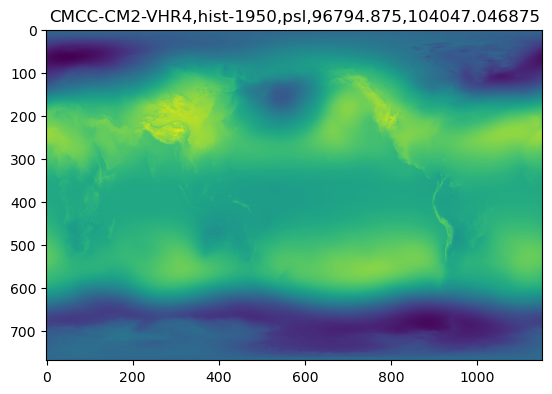

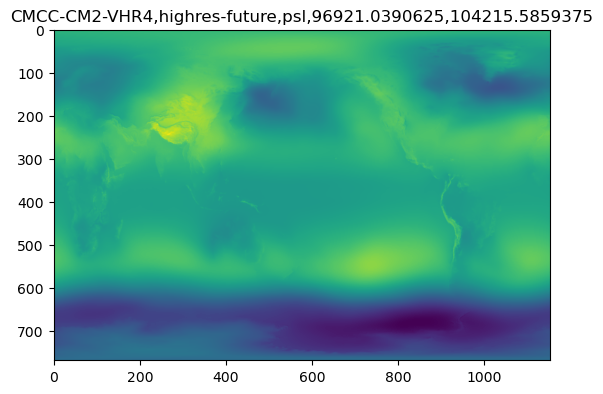

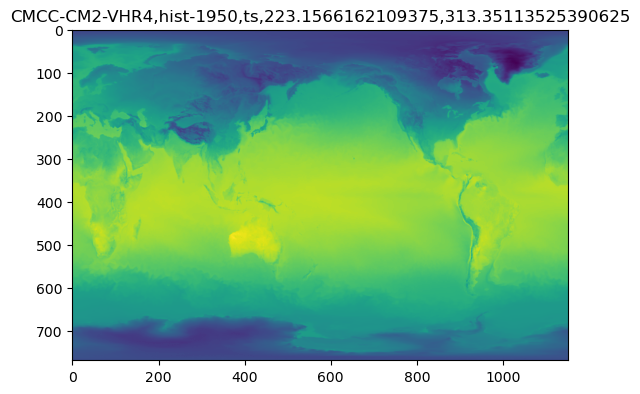

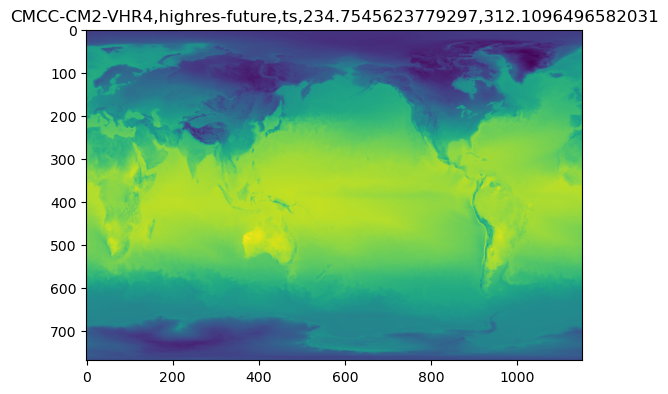

35.0


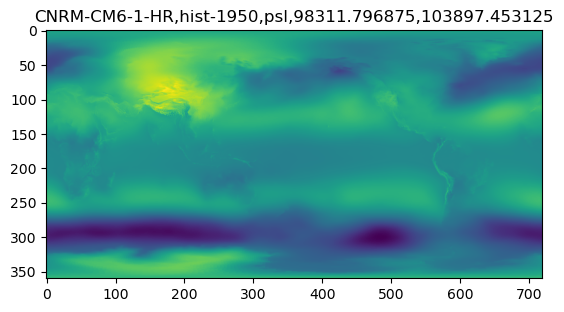

10.0


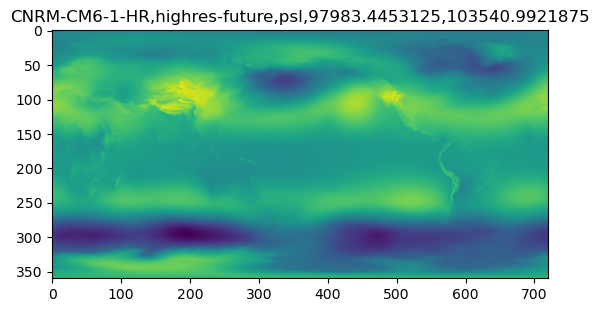

35.0


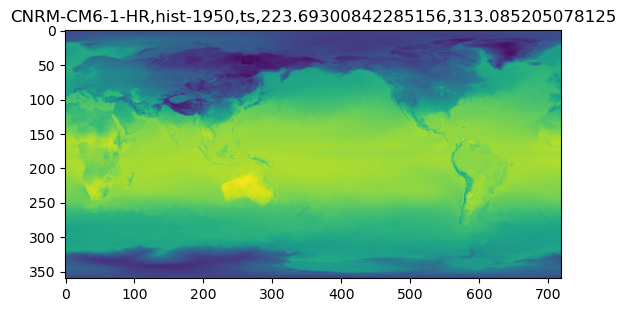

10.0


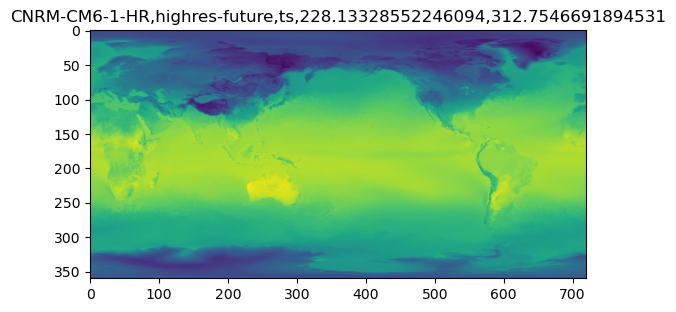

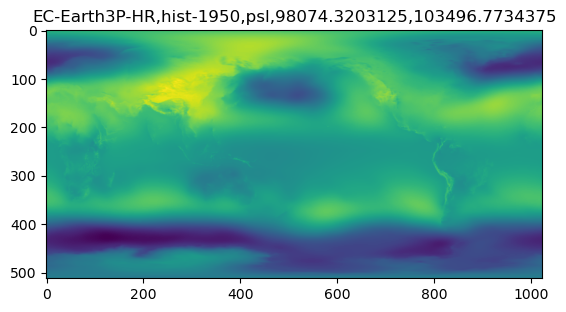

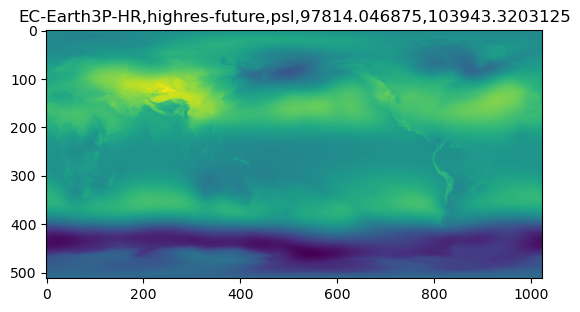

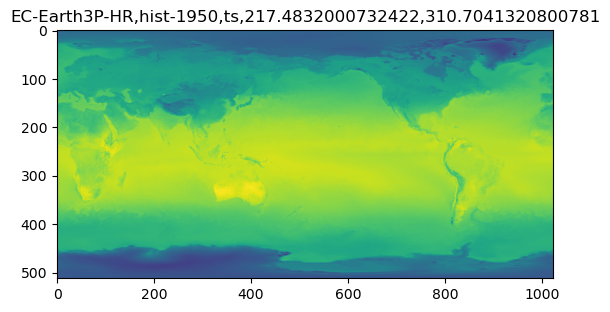

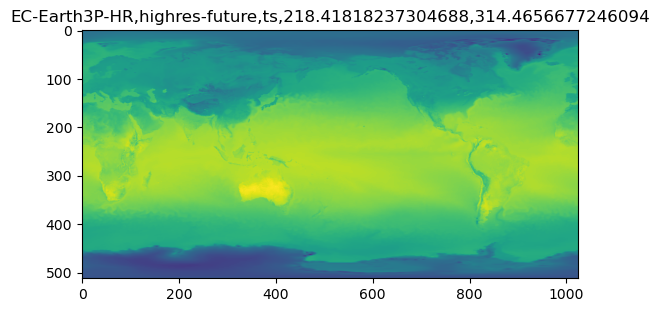

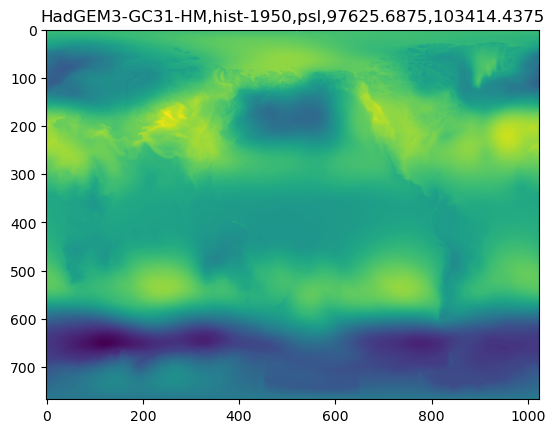

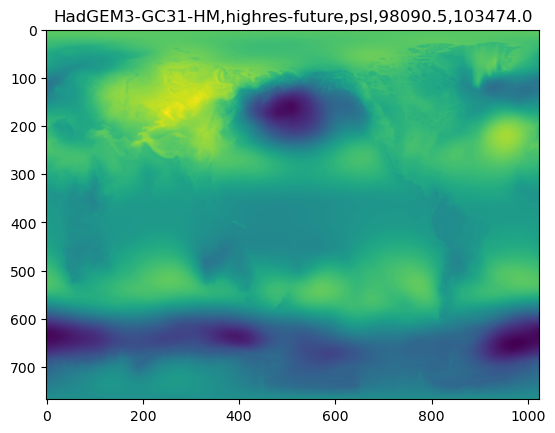

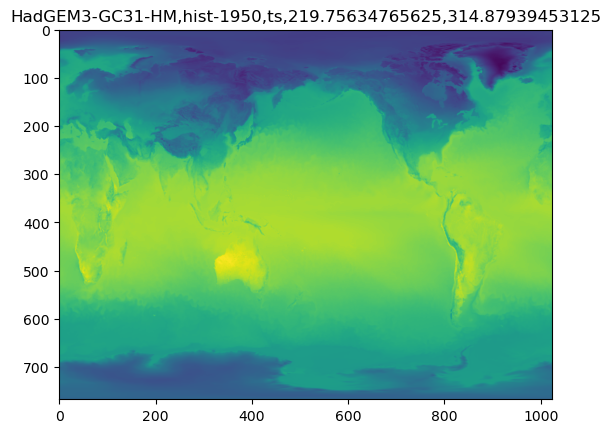

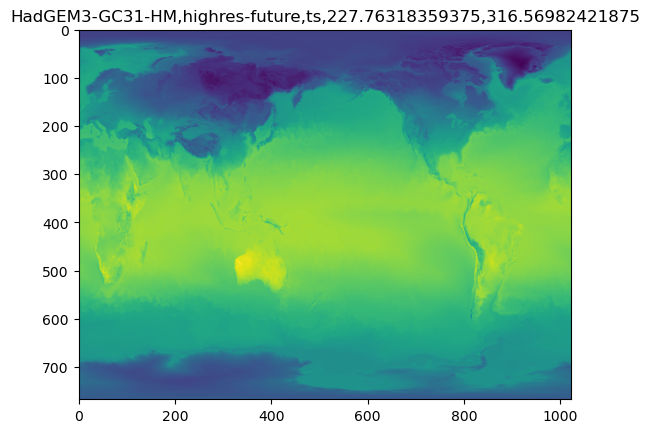

In [1]:
# -*- coding: utf-8 -*-
"""
Created on Wed Nov  4 15:34:51 2020

@author: nbl370
"""
import numpy as np
import xarray as xr 
import os
import matplotlib.pyplot as plt
import sys

__location__ = os.getcwd()


# ── USER SETTINGS: SSP2-4.5 equivalent to 2050 ──
YEARS_FUTURE = range(2034, 2044)       # 10 years: 2034–2043
FUTURE_TAG   = 'FUTURE_SSP245EQ2050'   # Used in filenames
OUTDIR       = os.path.join(__location__, 'Monthly_means', 'ssp245eq2050')
INPUTDIR = os.path.join(__location__, 'Input_Climate')
os.makedirs(OUTDIR, exist_ok=True)


for model,version,grid in zip(['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM'],['r1i1p1f1','r1i1p1f2','r1i1p2f1','r1i3p1f1'],['gn','gr','gr','gn']):

    for variable,variablename in zip(['psl','ts'],['MSLP','SST']):
        variable_all={i:[] for i in ['hist-1950','highres-future']}    
        if model=='CNRM-CM6-1-HR':
            for period,year0list,year1list in zip(['hist-1950','highres-future'],[[1980,1990,2000,2010],[2034]],[[1989,1999,2009,2014],[2043]]): #these go in batches of 10 years                
                variable_all[period]={i:np.zeros((360,720)) for i in range(1,13)}  
                count=0
                for year0,year1 in zip(year0list,year1list):
                        data=xr.open_dataset(os.path.join(INPUTDIR,'{}_Amon_{}_{}_{}_{}_{}01-{}12.nc'.format(variable,model,period,version,grid,year0,year1)), engine='netcdf4')
                        VARIABLE=data[variable]
                        #120 "time steps", so 1 per month, 10 years
                        for j in range(0,12): #12 months
                            for i in range(0,int(int(year1)-int(year0)+1)): #number of years
                                variable_all[period][int(j+1)]+=VARIABLE[i*12+j]
                                count+=1
                print(count/12)
                
               
                plt.imshow(np.flipud(VARIABLE[0]))
                plt.title('{},{},{},{},{}'.format(model,period,variable,np.nanmin(VARIABLE[0]),np.nanmax(VARIABLE[0])))
                plt.show()
                lonlat_data={i:[] for i in ['lat','lon']}
                lonlat_data['lon']=data['lon'].values
                lonlat_data['lat']=data['lat'].values 
                
                        
        elif model=='CMCC-CM2-VHR4':
            for period,yearlist in zip(['hist-1950','highres-future'],[np.arange(1979,2015,1),np.arange(2034,2044,1)]): #these go in batches of 10 years       
                variable_all[period]={i:np.zeros((768,1152)) for i in range(1,13)}
                for year in yearlist:
                    for month in ['01','02','03','04','05','06','07','08','09','10','11','12']:                    
                        data=xr.open_dataset(os.path.join(INPUTDIR,'{}_Amon_{}_{}_{}_{}_{}{}-{}{}.nc'.format(variable,model,period,version,grid,year,month,year,month)))
                        VARIABLE=data[variable]
                        
                        variable_all[period][int(month)]+=VARIABLE[0]
                                                       
                plt.imshow(np.flipud(VARIABLE[0]))
                plt.title('{},{},{},{},{}'.format(model,period,variable,np.nanmin(VARIABLE[0]),np.nanmax(VARIABLE[0])))
                plt.show()
                lonlat_data={i:[] for i in ['lat','lon']}
                lonlat_data['lon']=data['lon'].values
                lonlat_data['lat']=data['lat'].values 
        
        else: #HadGEM or EC-Earth
            for period,year0,year1 in zip(['hist-1950','highres-future'],[1979,YEARS_FUTURE.start],[2015,YEARS_FUTURE.stop]): #these go in batches of 10 years
                if model=='HadGEM3-GC31-HM':
                    variable_all[period]={i:np.zeros((768,1024)) for i in range(1,13)} 
                else: #EC-Earth3P-HR
                    variable_all[period]={i:np.zeros((512,1024)) for i in range(1,13)} 
                for year in range(year0,year1):             
                    data=xr.open_dataset(os.path.join(INPUTDIR,'{}_Amon_{}_{}_{}_{}_{}01-{}12.nc'.format(variable,model,period,version,grid,year,year)))
                    VARIABLE=data[variable].values
                    
                    for month in range(0,12):
                        variable_all[period][int(month)+1]+=VARIABLE[month]
                  
                plt.imshow(np.flipud(VARIABLE[0]))
                plt.title('{},{},{},{},{}'.format(model,period,variable,np.nanmin(VARIABLE[0]),np.nanmax(VARIABLE[0])))
                plt.show()
                lonlat_data={i:[] for i in ['lat','lon']}
                lonlat_data['lon']=data['lon'].values
                lonlat_data['lat']=data['lat'].values               
                    
        var=0
        for period,periodname in zip(['hist-1950','highres-future'],['PRESENT', FUTURE_TAG]):
            for month in range(1,13):
                if period == 'highres-future':
                    average = variable_all[period][month] / len(YEARS_FUTURE)  # = 10
                elif model == 'CNRM-CM6-1-HR' and period == 'hist-1950':
                    average = variable_all[period][month] / 35.
                else:
                    average = variable_all[period][month] / 36.
               
                if variable=='psl' and np.nanmean(average)>3000: #then it's in Pa:
                    average/=100. #convert to hPa
                
                if lonlat_data['lon'][0]<0: #then it's -180-180 projection
                    print('Converted',model,variable,period)
                    plt.imshow(np.flipud(average))
                    plt.show()
                    
                    lon = lonlat_data['lon']
                    lat = lonlat_data['lat']
                    
                    lon_converted=np.concatenate([lonlat_data['lon'][int(len(lon)/2):],lonlat_data['lon'][:int(len(lon)/2)]+360.],axis=0)   
                
                    lonlat_converted={'lat':lat,'lon':lon_converted}
                    
                    (latdim,londim)=average.shape
                    
                    average=np.concatenate([average[:,int(londim/2):],average[:,:int(londim/2)]],axis=1)
                    
                    var=1                
                    
                
                np.savetxt(os.path.join(OUTDIR, 'Monthly_mean_{}_{}_{}_{}.txt'.format(variablename, model, month, periodname)), average)
            
        if var==0:
            np.save(os.path.join(__location__,'latlon_background_converted_{}.npy'.format(model)),lonlat_data)
        else:
            np.save(os.path.join(__location__,'latlon_background_converted_{}.npy'.format(model)),lonlat_converted)





# Step1B_Mask_land_SST_means

In [11]:
# -*- coding: utf-8 -*-
"""
Created on Thu Jan 28 09:52:17 2021

@author: nbl370
"""
import netCDF4
import numpy as np
from osgeo import gdal,osr,ogr
import matplotlib.pyplot as plt
import os
import xarray as xr

__location__ = os.getcwd()
INDIR = os.path.join(__location__, 'Monthly_means', 'ssp245eq2050')



def makeMask1(lon,lat):
    source_ds = ogr.Open(os.path.join(__location__,'ne_10m_land.shp'))
    #YOU CAN DOWNLOAD THE LAND MASK HERE https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-land/ 
    source_layer = source_ds.GetLayer()
 
    # Create high res raster in memory
    mem_ds = gdal.GetDriverByName('MEM').Create('', lon.size, lat.size, gdal.GDT_Byte)
    mem_ds.SetGeoTransform((lon.min(), lon[:][1] - lon[:][0], 0, lat.max(), 0, (lat[:][1] - lat[:][0])))
    band = mem_ds.GetRasterBand(1)
 
    # Rasterize shapefile to grid
    gdal.RasterizeLayer(mem_ds, [1], source_layer, burn_values=[1])
 
    # Get rasterized shapefile as numpy array
    array = band.ReadAsArray()
 
    # Flush memory file
    mem_ds = None
    band = None
    return array
 
for model in ['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']: 
    data=np.load(os.path.join(__location__,'latlon_background_converted_{}.npy'.format(model)),allow_pickle=True).item()
    new_data={i:[] for i in ['lat','lon']}

    lat=data['lat']
    lon=data['lon']
    
    lons=[]
    for i in range(len(lon)):
        if lon[i]>180.:
            lons.append(lon[i]-360)
        else:
            lons.append(lon[i])
    
    lons=np.array(lons)
    
    lats=lat[::-1]
    
    new_data['lat']=lats
    new_data['lon']=lon
    
    print(lats)
    
    np.save(os.path.join(INDIR,'latlon_background_flipped_{}.npy'.format(model)),new_data)
    
    for period in ['PRESENT', 'FUTURE_SSP245EQ2050']:
 
        for month in range(1,13):
            data=np.loadtxt(os.path.join(INDIR,'Monthly_mean_SST_{}_{}_{}.txt'.format(model,month,period)))
            
            # create the mask -first run this part!
            mask1 = makeMask1(lons,lats) 
            
            mask=np.concatenate([mask1[:,int(len(lons)/2):],mask1[:,:int(len(lons)/2)]],axis=1)
            mask=np.flipud(mask)
            
            masked_variable=np.zeros((len(lat),len(lon)))
            
            for i in range(len(lat)):
                for j in range(len(lon)):
                    if mask[i,j]==1:
                        masked_variable[i,j]=np.nan
                    else:
                        masked_variable[i,j]=data[i,j]

            MSLP=np.loadtxt(os.path.join(INDIR,'Monthly_mean_MSLP_{}_{}_{}.txt'.format(model,month,period)))

            SST=np.flipud(masked_variable)
            MSLP=np.flipud(MSLP)

            np.savetxt(os.path.join(INDIR,'Monthly_mean_SST_{}_{}_{}_masked_flipped.txt'.format(model,month,period)),SST)
            np.savetxt(os.path.join(INDIR,'Monthly_mean_MSLP_{}_{}_{}_flipped.txt'.format(model,month,period)),MSLP)


[ 90.          89.76531943  89.53063885  89.29595828  89.06127771
  88.82659713  88.59191656  88.35723598  88.12255541  87.88787484
  87.65319426  87.41851369  87.18383312  86.94915254  86.71447197
  86.4797914   86.24511082  86.01043025  85.77574967  85.5410691
  85.30638853  85.07170795  84.83702738  84.60234681  84.36766623
  84.13298566  83.89830508  83.66362451  83.42894394  83.19426336
  82.95958279  82.72490222  82.49022164  82.25554107  82.0208605
  81.78617992  81.55149935  81.31681877  81.0821382   80.84745763
  80.61277705  80.37809648  80.14341591  79.90873533  79.67405476
  79.43937419  79.20469361  78.97001304  78.73533246  78.50065189
  78.26597132  78.03129074  77.79661017  77.5619296   77.32724902
  77.09256845  76.85788787  76.6232073   76.38852673  76.15384615
  75.91916558  75.68448501  75.44980443  75.21512386  74.98044329
  74.74576271  74.51108214  74.27640156  74.04172099  73.80704042
  73.57235984  73.33767927  73.1029987   72.86831812  72.63363755
  72.3989569

KeyboardInterrupt: 

# Step1_Open_GCM_datasets

In [6]:

# -*- coding: utf-8 -*-
"""
Created on Thu Oct 15 13:12:35 2020

@author: Nadia Bloemendaal, nadia.bloemendaal@vu.nl

This script opens the TC datasets from the global climate models, and extracts the relevant STORM variables from them. 
!!! IMPORTANT !!! Please find more information on the GCM datasets in Roberts et al (2020) Projected Future Changes in Tropical Cyclones using the CMIP6 HighResMIP Multimodel
Ensemble", including information on where to find the GCM datasets. I cannot send you the datasets directly, these need to be downloaded via the Jasmin server so that they have a 
record of who is using their datasets. I will therefore NOT reply to such requests!

This script will generate a substantial amount of files. Some of these are used in the creation of the STORM input dataset, whereas other files can support in any validation
undertakings. I therefore left everything in, but you can alter these output files if deemed necessary.

This script is part of the STORM Climate change research. Please read the corresponding paper before commercing.
Bloemendaal et al (2022) A globally consistent local-scale assessment of future tropical cyclone risk. Paper published in Science Advances.

Copyright (C) 2020 Nadia Bloemendaal. All versions realeased under the GNU General Public License v3.0.
"""

import numpy as np 
import xarray as xr 
import pandas as pd
import datetime
from SELECT_BASIN import Basins_WMO #YOU CAN FIND THIS SCRIPT UNDER THE STORM DIRECTORY ON GITHUB
from scipy import stats
import os
import sys


starttime=datetime.datetime.now()

YEARS_FUTURE = range(2034, 2044)  # SSP 2-4.5 equivalent to 2050
FUTURE_TAG = 'FUTURE_SSP245EQ2050'



def Check_EP_formation(lat,lon): 
    """
    Check if formation is in Eastern Pacific (this should be inhibited if basin==NA)
    Parameters
    ----------
    lat : latitude coordinate of genesis.
    lon : longitude coordinate of genesis

    Returns
    -------
    l : 1=yes (formation in EP),0=no (no formation in EP).

    """    
    if lat<=60. and lon<260.:
        l=1
    elif lat<=17.5 and lon<270.:
        l=1
    elif lat<=15. and lon<275.:
        l=1
    elif lat<=10. and lon<276.:
        l=1
    elif lat<=9. and lon<290.:
        l=1
    else:
        l=0
    return l
    
    
def Check_NA_formation(lat,lon): 
    """
    Check if formation is in North Atlantic (this should be inhibited if basin==EP)
    Parameters
    ----------
    lat : latitude coordinate of genesis
    lon : longitude coordinate of genesis

    Returns
    -------
    l : 1=yes (formation in NA) 0=no (no formation in NA).

    """
    if lat<=60. and lat>17.5 and lon>260.:
        l=1
    elif lat<=17.5 and lat>15. and lon>270.:
        l=1
    elif lat<=15. and lat>10 and lon>275.:
        l=1
    elif lat<=10. and lon>276.:
        l=1
    else:
        l=0
    return l

def genesis_basin(lat_genesis,lon_genesis):
    """
    Check if genesis location is inside WMO basin boundaries
    
    Parameters
    ----------
    lat_genesis : latitude genesis
    lon_genesis : longitude genesis (between 0-360)

    Returns
    -------
    basin : basin name. If location is not inside basin, None is returned. 

    """
    var=0
    for basin in ['EP','NA','NI','WP','SP','SI']:
        _, _,lat0,lat1,lon0,lon1=Basins_WMO(basin)
        if lat0<=lat_genesis<=lat1 and lon0<=lon_genesis<=lon1:
            if basin=='EP':
                check=Check_EP_formation(lat_genesis,lon_genesis) #1=EP 0=NA
                if check==1:
                    return 'EP'
                else:
                    return 'NA'
            elif basin=='NA':
                check=Check_NA_formation(lat_genesis,lon_genesis) #1=NA 0=EP
                if check==0:
                    return 'EP'
                else:
                    return 'NA'
            else:
                return basin
    if var==0:
        return None
    
 
monthsall={'EP':[6,7,8,9,10,11],'NA':[6,7,8,9,10,11],'NI':[4,5,6,9,10,11],'SI':[1,2,3,4,11,12],'SP':[1,2,3,4,11,12],'WP':[5,6,7,8,9,10,11]}
 
#'CMCC-CM2-VHR4'
for model in ['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']:  
    for period in ['PRESENT','FUTURE']:
        Path_File=r'K:\CMS\Internal\Personal\Mona\Hurricane\Adjustment_Gallagher\STORM_Code\STORM-climate-change-main\STORM-climate-change-main'
        __datasets__=os.path.realpath(Path_File)
        __location__ = os.path.join(os.getcwd(), 'data')
        os.makedirs(__location__, exist_ok=True)  # Ensure the 'data' directory exists
                
        months={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        genesis_pressure={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        genesis_location={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        genesis_dpres={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        genesis_pres_var={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        poisson={i:[0] for i in ['EP','NA','NI','SI','SP','WP']}
        poisson_list={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        
        tracks_latitude={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        tracks_longitude={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        tracks_pressure={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        tracks_wind={i:[] for i in ['EP','NA','NI','SI','SP','WP']}   
        tracks_month={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        
        per_year={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        years_list={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        
        track={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        pressure_model={i:[] for i in ['EP','NA','NI','SI','SP','WP']} 
        
        mean_pressure={i:[] for i in ['EP','NA','NI','SI','SP','WP']}
        min_pressure={i:[] for i in ['EP','NA','NI','SI','SP','WP']} 
        max_wind={i:[] for i in ['EP','NA','NI','SI','SP','WP']} 
        
        
        for basin in ['EP','NA','NI','SI','SP','WP']:
            genesis_pressure[basin]={j:[] for j in monthsall[basin]}
            genesis_location[basin]={j:[] for j in monthsall[basin]}
            genesis_dpres[basin]={j:[] for j in monthsall[basin]}
            genesis_pres_var[basin]={j:[] for j in monthsall[basin]}         
                
            tracks_latitude[basin]={i:[] for i in range(2000)}
            tracks_longitude[basin]={i:[] for i in range(2000)}
            tracks_pressure[basin]={i:[] for i in range(2000)}
            tracks_wind[basin]={i:[] for i in range(2000)}   
            tracks_month[basin]={i:[] for i in range(2000)}   
            years_list[basin]={i:[] for i in range(2000)}
    
            if period=='PRESENT':
                per_year[basin]={i:[0] for i in range(1979,2015)}
        
            else:
                per_year[basin]={i:[0] for i in YEARS_FUTURE }
            
            track[basin]={i:[] for i in range(0,6)}
            pressure_model[basin]={i:[] for i in range(0,6)}    

        count=0
                    
            
        for hemisphere in ['NH']:
            print(model,hemisphere,period,datetime.datetime.now()-starttime)
        
            data=xr.open_dataset(os.path.join(__datasets__,'data', 'TC-'+str(hemisphere)+'_TRACK_'+str(model)+'_'+str(period)+'.nc'))
            first_point=data['FIRST_PT'].values #first point of track
            no_point=data['NUM_PTS'].values #number of points in track
            track_id=data['TRACK_ID'].values #track_id (0-5321)
            pressure=data['psl'].values #pressure
            longitude=data['lon'].values #longitude from TRACK algorithm
            latitude=data['lat'].values #latitude from TRACK algorithm
            wind=data['sfcWind'].values #near-surface wind speed (10-meter)
            time=data['time'].values #datetime64    
           
            idx0=[i for i in range(len(time)) if int(str(time[i])[:4])>1978][0]
            idx0=np.argmax(first_point>idx0)-1
            
            #present-climate: (full range) 01/01/1950-30/12/2014
            #we take 01/01/1979 - 30/12/2014 to also have 36 years that most closely correspond
            #to the 38-year time period in IBTrACS.
            #future-climate: 01/01/2015-30/12/2050
     
            for i in range(idx0,len(first_point)):
                start=first_point[i]
                end=first_point[i]+no_point[i]
                
                windlist=wind[start:end]
                idx=np.where(windlist>=0)[0] #no threshold
                if len(idx)>1.:
                    j0=idx[0]   #first index where u>threshold
                    j1=idx[-1]+1  #last index where u>threshold
                
                    lonlist=longitude[start:end][j0:j1]
                    latlist=latitude[start:end][j0:j1]
                    preslist=pressure[start:end][j0:j1]
                    windlist=wind[start:end][j0:j1]
                    
                    #Check if genesis occurs inside a predefined basin
                    basin=genesis_basin(latlist[0],lonlist[0]) 
                    if basin!=None:
                        _, _,lat0,lat1,lon0,lon1=Basins_WMO(basin)
                        
                        basinlist=[basin for _ in lonlist]                                 
                    
                        #Explicitly create the datetime-object as every model has its own way of defining time.
                        timelist=[]                        
                        time_dummy=time[start:end][j0:j1]
    
                        for j in range(0,len(time_dummy)):
                            date_time_str=str(time_dummy[j])
                            
                            if model=='HadGEM3-GC31-HM':
                                if j==0:
                                    newyear=datetime.datetime.strptime(date_time_str[:4]+'-01-01 00:00:00', '%Y-%m-%d %H:%M:%S') 
                                    year_baseline=int(date_time_str[:4])
                                    
                                #calculate the number of hours between 1 January [year] and the actual day, in a 30-day world
                                year0=int(date_time_str[:4])
                                month0=int(date_time_str[5:7])
                                day0=int(date_time_str[8:10])
                                hour0=int(date_time_str[11:13])
                                
                                #total number of days
                                total_days=(year0-year_baseline)*360+30*(month0-1)+(day0-1)
                                
                                #convert to hours
                                total_hours=total_days*24+hour0  

                                date_time_obj=newyear+datetime.timedelta(hours=total_hours)

                            elif model =='CNRM-CM6-1-HR' or model=='EC-Earth3P-HR':
                                date_time_obj=datetime.datetime.strptime(date_time_str[:19], '%Y-%m-%dT%H:%M:%S')
                            else:                             
                                date_time_obj=datetime.datetime.strptime(date_time_str, '%Y-%m-%d %H:%M:%S')
                                
                            timelist.append(date_time_obj)                      
    
                        df=pd.DataFrame({'Latitude':latlist,'Longitude':lonlist,'Time':timelist,'Pressure':preslist,'Wind':windlist},index=None)
                        
                        df['Datetime']=pd.to_datetime(df['Time'])
                        df=df.set_index('Datetime')
                        df1=df.resample('3h').interpolate(method='linear')
                        basinlist=[basin for _ in df1['Longitude'].tolist()]
                        df1['Basin']=basinlist
                        df1['Hour']=df1.index.hour
                        df1['Month']=df1.index.month
                        df1['Year']=df1.index.year
                        df1=df1.reset_index()
                             

                        if (int(df1['Month'][0]) in monthsall[basin]) and \
                           ((period == 'PRESENT' and df1['Year'][0] >= 1979) or \
                            (period != 'PRESENT' and df1['Year'][0] in YEARS_FUTURE)):
                            #cut off data outside basin boundaries
                            df1=df1[(df1['Latitude']>=lat0) & (df1['Latitude']<=lat1) & (df1['Longitude']>=lon0) & (df1['Longitude'])<=lon1]
    
                            basin=df1['Basin'][0]
                            month=df1['Month'][0]
                            year=df1['Year'][0]
                            poisson[basin][0]+=1 
                            
                            per_year[basin][int(year)][0]+=1
                            
                            months[basin].append(month)                            
                            years_list[basin][count]=int(year)
                            count+=1
                            mean_pressure[basin].append(np.mean(df1['Pressure']))
                            min_pressure[basin].append(np.min(df1['Pressure']))
                            max_wind[basin].append(np.max(df1['Wind']))
                            
                            tracks_latitude[basin][count]=df1['Latitude'].tolist()
                            tracks_longitude[basin][count]=df1['Longitude'].tolist()
                            tracks_pressure[basin][count]=df1['Pressure'].tolist()
                            tracks_wind[basin][count]=df1['Wind'].tolist()
                            
                            tracks_month[basin][count]=month
                            
                            count+=1
    
                            genesis_pressure[basin][month].append(df1['Pressure'][0])
                            genesis_location[basin][month].append([df1['Latitude'][0],df1['Longitude'][0]])
                            genesis_dpres[basin][month].append(df1['Pressure'][1]-df1['Pressure'][0])
                            
                            for j in range(1,len(df1['Latitude'])-1):
                                track[basin][0].append(df1['Latitude'][j]-df1['Latitude'][j-1])
                                track[basin][1].append(df1['Latitude'][j+1]-df1['Latitude'][j])
                                track[basin][2].append(df1['Longitude'][j]-df1['Longitude'][j-1])
                                track[basin][3].append(df1['Longitude'][j+1]-df1['Longitude'][j])
                                track[basin][4].append(df1['Latitude'][j])
                                track[basin][5].append(df1['Longitude'][j])
                                
                                pressure_model[basin][0].append(df1['Pressure'][j]-df1['Pressure'][j-1])
                                pressure_model[basin][1].append(df1['Pressure'][j+1]-df1['Pressure'][j])
                                pressure_model[basin][2].append(df1['Pressure'][j])
                                pressure_model[basin][3].append(df1['Latitude'][j])
                                pressure_model[basin][4].append(df1['Longitude'][j])
                                pressure_model[basin][5].append(month)
                                      
        dp0_neg,dp0_pos=[],[] 
        for basin in ['EP','NA','NI','SI','SP','WP']:                            
        
            for j in range(len(pressure_model[basin][0])):
                if pressure_model[basin][0][j]<0.:
                    dp0_neg.append(pressure_model[basin][0][j])
                elif pressure_model[basin][0][j]>0:
                    dp0_pos.append(pressure_model[basin][0][j])
        
        
            pneg=np.percentile(dp0_neg,1)
            ppos=np.percentile(dp0_pos,99)  


            for month in monthsall[basin]:
                dplist = [v for v in genesis_dpres[basin][month] if np.isnan(v) == False and v > -1000.]
                plist = [v for v in genesis_pressure[basin][month] if np.isnan(v) == False and v > 0.]
            
                if dplist:
                    mudp0, stddp0 = stats.norm.fit(dplist)
                else:
                    mudp0, stddp0 = np.nan, np.nan
            
                if plist:
                    mupres, stdpres = stats.norm.fit(plist)
                else:
                    mupres, stdpres = np.nan, np.nan
            
                genesis_pres_var[basin][month] = [mupres, stdpres, mudp0, stddp0, pneg, ppos]
            

                
            poisson_list[basin] = [poisson[basin][0] / (36. if period == 'PRESENT' else len(YEARS_FUTURE))]

                                      
        tag = FUTURE_TAG if period != 'PRESENT' else 'PRESENT'

        np.save(os.path.join(__location__,'POISSON_GENESIS_PARAMETERS_'+tag+'_'+str(model)+'_nothres.npy'), poisson_list)
        np.save(os.path.join(__location__,'TC_TRACK_VARIABLES_'+tag+'_'+str(model)+'_nothres.npy'), track)
        np.save(os.path.join(__location__,'TC_PRESSURE_VARIABLES_'+tag+'_'+str(model)+'_nothres.npy'), pressure_model)
        np.save(os.path.join(__location__,'DP0_PRES_GENESIS_'+tag+'_'+str(model)+'_nothres.npy'), genesis_pres_var)

        np.save(os.path.join(__location__,'DP_GEN_'+tag+'_'+str(model)+'_nothres.npy'), genesis_dpres)
        np.save(os.path.join(__location__,'PRES_GEN_'+tag+'_'+str(model)+'_nothres.npy'), genesis_pressure)
        np.save(os.path.join(__location__,'GEN_LOC_'+tag+'_'+str(model)+'_nothres.npy'), genesis_location, fix_imports=True)
        np.save(os.path.join(__location__,'GENESIS_MONTHS_'+tag+'_'+str(model)+'_nothres.npy'), months)
        np.save(os.path.join(__location__,'GENESIS_YEARS_'+tag+'_'+str(model)+'_nothres.npy'), years_list)

        np.save(os.path.join(__location__,'FREQUENCY_PER_YEAR_'+tag+'_'+str(model)+'_nothres.npy'), per_year)

        np.save(os.path.join(__location__,'TC_TRACK_LATITUDE_'+tag+'_'+str(model)+'_nothres.npy'), tracks_latitude)
        np.save(os.path.join(__location__,'TC_TRACK_LONGITUDE_'+tag+'_'+str(model)+'_nothres.npy'), tracks_longitude)
        np.save(os.path.join(__location__,'TC_TRACK_PRESSURE_'+tag+'_'+str(model)+'_nothres.npy'), tracks_pressure)
        np.save(os.path.join(__location__,'TC_TRACK_WIND_'+tag+'_'+str(model)+'_nothres.npy'), tracks_wind)
        np.save(os.path.join(__location__,'TC_TRACK_MONTH_'+tag+'_'+str(model)+'_nothres.npy'), tracks_month)

        np.save(os.path.join(__location__,'TC_MEAN_PRESSURE_'+tag+'_'+str(model)+'_nothres.npy'), mean_pressure)
        np.save(os.path.join(__location__,'TC_MIN_PRESSURE_'+tag+'_'+str(model)+'_nothres.npy'), min_pressure)
        np.save(os.path.join(__location__,'TC_MAX_WIND_'+tag+'_'+str(model)+'_nothres.npy'), max_wind)


CMCC-CM2-VHR4 NH PRESENT 0:00:00.044902
CMCC-CM2-VHR4 NH FUTURE 0:02:38.587117
CNRM-CM6-1-HR NH PRESENT 0:04:41.744263
CNRM-CM6-1-HR NH FUTURE 0:07:25.313485
EC-Earth3P-HR NH PRESENT 0:09:23.782660
EC-Earth3P-HR NH FUTURE 0:11:02.217013
HadGEM3-GC31-HM NH PRESENT 0:12:17.613417
HadGEM3-GC31-HM NH FUTURE 0:16:08.128910


# Step2_Calculate_track_coefficients

In [8]:
# -*- coding: utf-8 -*-
"""
This module is part of the STORM model

For more information, please see 
Bloemendaal, N., Haigh, I.D., de Moel, H. et al. 
Generation of a global synthetic tropical cyclone hazard dataset using STORM. 
Sci Data 7, 40 (2020). https://doi.org/10.1038/s41597-020-0381-2

Functions described here are part of the data pre-processing and derive the coefficients
of the regression formulas. These coefficients will not be used directly in the delta approach (some of the other output variables will). But it's good to keep these coefficients
in case you want to run the GCMs directly through STORM.

Copyright (C) 2020 Nadia Bloemendaal. All versions released under the GNU General Public License v3.0
"""

import numpy as np
from scipy.stats import norm
import pandas as pd
from scipy.optimize import curve_fit
import os
import sys
dir_path=os.path.dirname(os.path.realpath(sys.argv[0]))
__location__ = os.getcwd()
FUTURE_TAG = 'FUTURE_SSP245EQ2050'


def BOUNDARIES_BASINS(idx):
    if idx=='EP': #Eastern Pacific
        lat0,lat1,lon0,lon1=5,60,180,285
    if idx=='NA': #North Atlantic
        lat0,lat1,lon0,lon1=5,60,255,359
    if idx=='NI': #North Indian
        lat0,lat1,lon0,lon1=5,60,30,100
    if idx=='SI': #South Indian
        lat0,lat1,lon0,lon1=-60,-5,10,135
    if idx=='SP': #South Pacific
        lat0,lat1,lon0,lon1=-60,-5,135,240
    if idx=='WP': #Western Pacific
        lat0,lat1,lon0,lon1=5,60,100,180
    
    return lat0,lat1,lon0,lon1

def LATFUNCTION(X,a,b,c):
    """
    This is the regression function for the latitudinal movement of the TC. This function returns the values
    of the coefficients a,b,c.
    Parameters
    ----------
    X : array of delta-latitude and latitude ([dlat,lat])
    a,b,c : coefficients of regression function for latitude
    """
    dlat,lat=X
    return a+b*dlat+c/lat

def LATEXPECTED(dlat,lat,a,b,c):
    """
    Calculate the expected forward change in latitude.
    
    Parameters
    ----------
    dlat : backward change in latitude (lat[i]-lat[i-1])
    lat : latitude
    a,b,c: coefficient values

    Returns
    -------
    dlat1_list : array of forward change in latitude (lat[i+1]-lat[i])
    """
    dlat1_list=[]
    for k in range(len(dlat)):
        dlat1_list.append(a+b*dlat[k]+c/lat[k])
    return dlat1_list

def LONFUNCTION(x,a,b):
    """
    This is the regression formula for the longitudinal movement of the TC. This function 
    returns optimal fit values of the coefficients a and b. 
    Parameters
    ----------
    x : backward change in longitude (dlon0; lon[i]-lon[i-1]).
    a,b: coefficients

    """
    return a+b*x

def LONEXPECTED(x,a,b):
    """
    Parameters
    ----------
    x : list of backward change in longitude (dlon0; lon[i]-lon[i-1]).
    a,b : coefficients.

    Returns
    -------
    dlon1_list : array of forward change in longitude (lon[i+1]-lon[i])

    """
    dlon1_list=[]
    for k in range(len(x)):
        dlon1_list.append(a+b*x[k])
    return dlon1_list


from tqdm import tqdm

def track_coefficients(period, model):
    """
    Calculate the track coefficients. This function returns a npy-file with the coefficients
    per 5 deg bin for every basin. 
    """
    step = 5.
    print(f"\n🔄 Starting: {model} — {period}")

    data = np.load(os.path.join(__location__, 'data', f'TC_TRACK_VARIABLES_{period}_{model}_nothres.npy'), allow_pickle=True).item()
    coefficients_list = {i: [] for i in range(6)}  # for every basin

    for basin, idx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        print(f"\n🌀 Processing basin {basin}")

        df = pd.DataFrame({
            'Latitude': data[basin][4],
            'Longitude': data[basin][5],
            'Dlat0': data[basin][0],
            'Dlat1': data[basin][1],
            'Dlon0': data[basin][2],
            'Dlon1': data[basin][3]
        })
        lat0, lat1, lon0, lon1 = BOUNDARIES_BASINS(basin)

        df = df[(df['Latitude'] <= lat1) & (df['Latitude'] >= lat0) &
                (df['Longitude'] <= lon1) & (df['Longitude'] >= lon0)]

        print(f"{basin}: number of rows after filtering = {len(df)}")

        latspace = np.linspace(lat0, lat1 - 5., int(abs(lat0 - lat1 + 5) / step) + 1)
        to_bin = lambda x: np.floor(x / step) * step
        df["latbin"] = df.Latitude.map(to_bin)

        Dlat0_group = df.groupby("latbin")['Dlat0'].apply(list)
        Dlat1_group = df.groupby("latbin")['Dlat1'].apply(list)
        Dlon0_group = df.groupby("latbin")['Dlon0'].apply(list)
        Dlon1_group = df.groupby("latbin")['Dlon1'].apply(list)
        Lat_group = df.groupby("latbin")['Latitude'].apply(list)
        bins_values = np.unique(df["latbin"])

        # ✅ Skip if no valid bins
        valid_bin_count = sum(len(Dlat0_group[lat]) > 50 for lat in bins_values)
        if valid_bin_count == 0:
            print(f"⚠️ Skipping basin {basin} — not enough data for any regression bins.")
            continue

        coeff_array = [[0]] * len(latspace)
        count = 0

        for lat in tqdm(bins_values, desc=f"{basin} latbins"):
            i_ind = int((lat - lat0) / step)
            if len(Dlat0_group[lat]) > 50:
                Lat = Lat_group[lat]
                Dlat0 = Dlat0_group[lat]
                Dlat1 = Dlat1_group[lat]
                Dlon0 = Dlon0_group[lat]
                Dlon1 = Dlon1_group[lat]

                try:
                    opt, _ = curve_fit(LONFUNCTION, Dlon0, Dlon1)
                    a0, a1 = opt

                    expected = LONEXPECTED(Dlon0, a0, a1)
                    Elon = [expected[m] - Dlon1[m] for m in range(len(expected))]
                    Elonmu, Elonstd = norm.fit(Elon)

                    X = [Dlat0, Lat]
                    opt, _ = curve_fit(LATFUNCTION, X, Dlat1)
                    b0, b1, b2 = opt

                    Dlat1mu, Dlat1std = norm.fit(Dlat0)
                    Dlon1mu, Dlon1std = norm.fit(Dlon0)

                    expected = LATEXPECTED(Dlat0, Lat, b0, b1, b2)
                    Elat = [expected[m] - Dlat1[m] for m in range(len(expected))]
                    Elatmu, Elatstd = norm.fit(Elat)

                    if abs(Elatmu) < 1 and abs(Elonmu) < 1:
                        coeff_array[i_ind] = [a0, a1, b0, b1, b2,
                                              Elatmu, Elatstd, Elonmu, Elonstd,
                                              Dlat1mu, Dlat1std, Dlon1mu, Dlon1std]
                        count += 1
                except RuntimeError:
                    print("   ❌ No fit found")

        # ✅ Short-circuit if no coefficients were found
        if count == 0:
            print(f"⚠️ No valid coefficients found for {basin}. Skipping filling.")
            continue

        # Fill missing bins
        if basin in ['SI', 'SP']:
            while count < len(latspace):
                for i in reversed(range(len(latspace))):
                    if len(coeff_array[i]) == 1:
                        if i < len(latspace) - 1 and len(coeff_array[i + 1]) > 1:
                            coeff_array[i] = coeff_array[i + 1]
                            count += 1
                        elif i > 0 and len(coeff_array[i - 1]) > 1:
                            coeff_array[i] = coeff_array[i - 1]
                            count += 1
        else:
            while count < len(latspace):
                for i in range(len(latspace)):
                    if len(coeff_array[i]) == 1:
                        if i > 0 and len(coeff_array[i - 1]) > 1:
                            coeff_array[i] = coeff_array[i - 1]
                            count += 1
                        elif i < len(latspace) - 1 and len(coeff_array[i + 1]) > 1:
                            coeff_array[i] = coeff_array[i + 1]
                            count += 1

        coefficients_list[idx] = coeff_array

    np.save(os.path.join(__location__, 'data', f'JM_LONLATBINS_{period}_{model}_nothres.npy'), coefficients_list)
    print(f"✅ Saved coefficients for {model}, {period}")

# def track_coefficients(period,model):
#     """
#     Calculate the track coefficients. This function returns a npy-file with the coefficients
#     per 5 deg bin for every basin. 
#     """
#     step=5.
           
#     data=np.load(os.path.join(__location__,'data','TC_TRACK_VARIABLES_{}_{}_nothres.npy'.format(period,model)),allow_pickle=True).item()
    
#     coefficients_list={i:[] for i in range(0,6)} #for every basin
    
#     for basin,idx in zip(['EP','NA','NI','SI','SP','WP'],range(0,6)):
               
#         df=pd.DataFrame({'Latitude':data[basin][4],'Longitude':data[basin][5],'Dlat0':data[basin][0],'Dlat1':data[basin][1],'Dlon0':data[basin][2],'Dlon1':data[basin][3]})
#         lat0,lat1,lon0,lon1=BOUNDARIES_BASINS(basin)
        
#         df=df[(df['Latitude']<=lat1) & (df['Latitude']>=lat0) & (df['Longitude']<=lon1) & (df['Longitude']>=lon0)]
            
#         latspace=np.linspace(lat0,lat1-5.,int(abs(lat0-lat1+5)/step)+1)
    
#         to_bin=lambda x:np.floor(x/step)*step
#         df["latbin"]=df.Latitude.map(to_bin)
#         Dlat0_group=df.groupby(["latbin"])['Dlat0'].apply(list)
#         Dlat1_group=df.groupby(["latbin"])['Dlat1'].apply(list)
#         Dlon0_group=df.groupby(["latbin"])['Dlon0'].apply(list)
#         Dlon1_group=df.groupby(["latbin"])['Dlon1'].apply(list)
#         Lat_group=df.groupby(["latbin"])['Latitude'].apply(list)
#         bins_values=np.unique(df["latbin"])   
    
#         coeff_array=[[0]]*len(latspace)
#         count=0  
#         for lat in bins_values:
#             i_ind=int((lat-lat0)/step)
#             if len(Dlat0_group[lat])>50.:
                
#                 Lat=Lat_group[lat]
#                 Dlat0=Dlat0_group[lat]
#                 Dlat1=Dlat1_group[lat]
#                 Dlon0=Dlon0_group[lat]
#                 Dlon1=Dlon1_group[lat]  
                 
#                 try:
#                     opt,l=curve_fit(LONFUNCTION,Dlon0,Dlon1)
#                     [a0,a1]=opt
                                        
#                     expected=LONEXPECTED(Dlon0,a0,a1)
#                     Elon=[]
#                     for m in range(len(expected)):
#                         Elon.append(expected[m]-Dlon1[m])
                    
#                     Elonmu,Elonstd=norm.fit(Elon)
    
#                     X=[Dlat0,Lat]
#                     opt,l=curve_fit(LATFUNCTION,X,Dlat1)
#                     [b0,b1,b2]=opt                
    
#                     Dlat1mu,Dlat1std=norm.fit(Dlat0)
                    
#                     Dlon1mu,Dlon1std=norm.fit(Dlon0)
    
#                     expected=LATEXPECTED(Dlat0,Lat,b0,b1,b2)
                    
#                     Elat=[]
#                     for m in range(len(expected)):
#                         Elat.append(expected[m]-Dlat1[m]) 
       
#                     Elatmu,Elatstd=norm.fit(Elat)    
        
#                     if abs(Elatmu)<1 and abs(Elonmu)<1: #otherwise: the fit didn't go as planned: large deviation from expected values..
#                         coeff_array[i_ind]=[a0,a1,b0,b1,b2,Elatmu,Elatstd,Elonmu,Elonstd,Dlat1mu,Dlat1std,Dlon1mu,Dlon1std]
#                         count=count+1
    
#                 except RuntimeError:
#                     print("No fit found") 
         
#         if basin=='SI' or basin=='SP': #Southern Hemisphere works the other way around           
#             while count<len(latspace):
#                 for i in reversed(range(len(latspace))):
#                     if len(coeff_array[i])==1:
#                         if i<len(latspace)-1 and len(coeff_array[i+1])>1:
#                             coeff_array[i]=coeff_array[i+1]
#                             count=count+1
#                         elif i>0 and len(coeff_array[i-1])>1.:
#                             coeff_array[i]=coeff_array[i-1]
#                             count=count+1
#         else:
#             while count<len(latspace):
#                 for i in range(len(latspace)):
#                     if len(coeff_array[i])==1:
#                         if i>0 and len(coeff_array[i-1])>1:
#                             coeff_array[i]=coeff_array[i-1]
#                             count=count+1
#                         elif i<len(latspace) and len(coeff_array[i+1])>1.:
#                             coeff_array[i]=coeff_array[i+1]
#                             count=count+1        
        
#         coefficients_list[idx]=coeff_array      
  
#     np.save(os.path.join(__location__,'data','JM_LONLATBINS_{}_{}_nothres.npy'.format(period,model)),coefficients_list)                    

for model in ['CMCC-CM2-VHR4','CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM']:  
    for period in ['PRESENT', FUTURE_TAG]:
        print(model, period)
        track_coefficients(period, model)



The history saving thread hit an unexpected error (OperationalError('database or disk is full')).History will not be written to the database.
CMCC-CM2-VHR4 PRESENT

🔄 Starting: CMCC-CM2-VHR4 — PRESENT

🌀 Processing basin EP
EP: number of rows after filtering = 107772


EP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 42.58it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 5639


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 578.92it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 16904


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 174.99it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 29
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 84204


WP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 66.26it/s]


✅ Saved coefficients for CMCC-CM2-VHR4, PRESENT
CMCC-CM2-VHR4 FUTURE_SSP245EQ2050

🔄 Starting: CMCC-CM2-VHR4 — FUTURE_SSP245EQ2050

🌀 Processing basin EP
EP: number of rows after filtering = 31665


EP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 164.04it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 1808


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 999.86it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 4402


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 461.55it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 22861


WP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 234.03it/s]


✅ Saved coefficients for CMCC-CM2-VHR4, FUTURE_SSP245EQ2050
CNRM-CM6-1-HR PRESENT

🔄 Starting: CNRM-CM6-1-HR — PRESENT

🌀 Processing basin EP
EP: number of rows after filtering = 70789


EP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 78.96it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 60040


NA latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 99.24it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 23680


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 160.87it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 65966


WP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 80.71it/s]


✅ Saved coefficients for CNRM-CM6-1-HR, PRESENT
CNRM-CM6-1-HR FUTURE_SSP245EQ2050

🔄 Starting: CNRM-CM6-1-HR — FUTURE_SSP245EQ2050

🌀 Processing basin EP
EP: number of rows after filtering = 18583


EP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 227.41it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 12847


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 357.69it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 4000


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 398.44it/s]


🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 15918



WP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 320.20it/s]


✅ Saved coefficients for CNRM-CM6-1-HR, FUTURE_SSP245EQ2050
EC-Earth3P-HR PRESENT

🔄 Starting: EC-Earth3P-HR — PRESENT

🌀 Processing basin EP
EP: number of rows after filtering = 66739


EP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 78.18it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 20639


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 227.79it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 7661


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 9/9 [00:00<00:00, 449.50it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 52733


WP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 100.22it/s]


✅ Saved coefficients for EC-Earth3P-HR, PRESENT
EC-Earth3P-HR FUTURE_SSP245EQ2050

🔄 Starting: EC-Earth3P-HR — FUTURE_SSP245EQ2050

🌀 Processing basin EP
EP: number of rows after filtering = 16400


EP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 261.02it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 3587


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 644.96it/s]


🌀 Processing basin NI


NI: number of rows after filtering = 3190


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 416.58it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 15272


WP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 311.85it/s]


✅ Saved coefficients for EC-Earth3P-HR, FUTURE_SSP245EQ2050
HadGEM3-GC31-HM PRESENT

🔄 Starting: HadGEM3-GC31-HM — PRESENT

🌀 Processing basin EP
EP: number of rows after filtering = 102278


EP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 62.99it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 44880


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 122.25it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 11297


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 245.00it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 7
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 120298


WP latbins: 100%|██████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 55.27it/s]


✅ Saved coefficients for HadGEM3-GC31-HM, PRESENT
HadGEM3-GC31-HM FUTURE_SSP245EQ2050

🔄 Starting: HadGEM3-GC31-HM — FUTURE_SSP245EQ2050

🌀 Processing basin EP
EP: number of rows after filtering = 30226


EP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 170.67it/s]



🌀 Processing basin NA
NA: number of rows after filtering = 10303


NA latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 407.40it/s]



🌀 Processing basin NI
NI: number of rows after filtering = 3149


NI latbins: 100%|███████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 454.56it/s]



🌀 Processing basin SI
SI: number of rows after filtering = 0
⚠️ Skipping basin SI — not enough data for any regression bins.

🌀 Processing basin SP
SP: number of rows after filtering = 0
⚠️ Skipping basin SP — not enough data for any regression bins.

🌀 Processing basin WP
WP: number of rows after filtering = 34253


WP latbins: 100%|█████████████████████████████████████████████████████████████████████| 11/11 [00:00<00:00, 171.39it/s]

✅ Saved coefficients for HadGEM3-GC31-HM, FUTURE_SSP245EQ2050


# Step3_Calculate_pressure_coefficients

In [12]:
# -*- coding: utf-8 -*-
"""
This module is part of the STORM model

For more information, please see 
Bloemendaal, N., Haigh, I.D., de Moel, H. et al. 
Generation of a global synthetic tropical cyclone hazard dataset using STORM. 
Sci Data 7, 40 (2020). https://doi.org/10.1038/s41597-020-0381-2

Functions described here are part of the data pre-processing and calculate the environmental
conditions + wind-pressure relationship.

This script is part of the STORM Climate change research. Please read the corresponding paper before commercing.
Bloemendaal et al (2022) A globally consistent local-scale assessment of future tropical cyclone risk. Paper published in Science Advances.

Copyright (C) 2020 Nadia Bloemendaal. All versions released under the GNU General Public License v3.0
"""

import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import curve_fit
import math
import os
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')


__location__ = os.getcwd()


FUTURE_TAG = 'FUTURE_SSP245EQ2050'

def BOUNDARIES_BASINS(idx):
    if idx=='EP': #Eastern Pacific
        lat0,lat1,lon0,lon1=0,60,180,285
    if idx=='NA': #North Atlantic
        lat0,lat1,lon0,lon1=0,60,255,360
    if idx=='NI': #North Indian
        lat0,lat1,lon0,lon1=0,60,30,100
    if idx=='SI': #South Indian
        lat0,lat1,lon0,lon1=-60,0,10,135
    if idx=='SP': #South Pacific
        lat0,lat1,lon0,lon1=-60,0,135,240
    if idx=='WP': #Western Pacific
        lat0,lat1,lon0,lon1=0,60,100,180
    
    return lat0,lat1,lon0,lon1

def PRESFUNCTION(X,a,b,c,d):
    """
    Fit the data to the pressure function. 
    Parameters
    ----------
    X : array of change in pressure and difference between pressure and mpi ([dp0,p-mpi])
    a,b,c,d : Coefficients

    """
    dp,presmpi=X
    return a+b*dp+c*np.exp(-d*presmpi)

def PRESEXPECTED(dp,presmpi,a,b,c,d):
    """
    Calculate the forward change in pressure (dp1, p[i+1]-p[i])    

    Parameters
    ----------
    dp : backward change in pressure (dp0, p[i]-p[i-1])
    presmpi : difference between pressure and mpi (p-mpi).
    a,b,c,d : coefficients

    Returns
    -------
    dp1_list : array of forward change in pressure (dp1, p[i+1]-p[i])

    """
    dp1_list=[]
    for k in range(len(dp)):
        dp1_list.append(a+b*dp[k]+c*np.exp(-d*presmpi[k]))
    return dp1_list

def MPI_function(T,A,B,C):
    """
    Fit the MPI function to the data. This function returns the optimal coefficients.
    Parameters
    ----------
    T : Sea-surface temperature in Celcius.
    A,B,C : coefficients 

    """
    return A+B*np.exp(C*(T-30.))

def Calculate_P(V,Penv,a,b):
    """
    Convert Vmax to Pressure following the empirical wind-pressure relationship (Harper 2002, Atkinson and Holliday 1977)
    
    Input: 
        Vmax: 10-min mean maximum wind speed in m/s
        Penv: environmental pressure (hPa)
        a,b: coefficients. See Atkinson_Holliday_wind_pressure_relationship.py
    
    Returns:
        Pc: central pressure in the eye
    
    """
    
    Pc=Penv-(V/a)**(1./b)  
    return Pc


def MPI_fields(period,model):
    data=np.load(os.path.join(__location__,'latlon_background_flipped_{}.npy'.format(model)),allow_pickle=True).item()

    lat=data['lat']
    lon=data['lon']
    
    coeflist=np.load(os.path.join(__location__,'COEFFICIENTS_MPI_PRESSURE_DROP_MONTH_new.npy'),allow_pickle=True,encoding='latin1').item()
    
    monthsall={'EP':[6,7,8,9,10,11],'NA':[6,7,8,9,10,11],'NI':[4,5,6,9,10,11],'SI':[1,2,3,4,11,12],'SP':[1,2,3,4,11,12],'WP':[5,6,7,8,9,10,11]}             
    mpibounds={'EP':[860,880,900,900,880,860],'NA':[920,900,900,900,880,880],'NI':[840,860,880,900,880,860],'SI':[840,880,860,860,840,860],'SP':[840,840,860,860,840,840],'WP':[860,860,860,870,870,860,860]}
    
    basinidx={'EP':0,'NA':1,'NI':2,'SI':3,'SP':4,'WP':5}
    
    MPI_all={i:[] for i in ['EP','NA','NI','SI','SP','WP']} 
    for basin in ['EP','NA','NI','SI','SP','WP']:
        MPI_all[basin]={i:[] for i in monthsall[basin]}
        
        for month,index in zip(monthsall[basin],range(len(monthsall[basin]))): 
            print(model,period,basin,month)
            
            [A,B,C]=coeflist[int(basinidx[basin])][month] 
            
            SST= np.loadtxt(os.path.join(__location__,'Monthly_means','ssp245eq2050','Monthly_mean_SST_{}_{}_{}_masked_flipped.txt'.format(model,month,period)))
            MSLP=np.loadtxt(os.path.join(__location__,'Monthly_means','ssp245eq2050','Monthly_mean_MSLP_{}_{}_{}_flipped.txt'.format(model,month,period)))
            
            lat0,lat1,lon0,lon1=BOUNDARIES_BASINS(basin)
            
            lat_0=np.abs(lat-lat0).argmin()
            lat_1=np.abs(lat-lat1).argmin()
            lon_0=np.abs(lon-lon0).argmin()
            lon_1=np.abs(lon-lon1-0.1).argmin()
                        
            SST_field=SST[lat_1:lat_0,lon_0:lon_1]
            MSLP_field=MSLP[lat_1:lat_0,lon_0:lon_1]
                                
            PC_MATRIX=np.zeros((SST_field.shape))
            PC_MATRIX[:]=np.nan
                    
            PRESDROP=MPI_function(SST_field-273.15,A,B,C) #Vmax is given in m/s
            PC_MATRIX=MSLP_field-PRESDROP
            boundary=mpibounds[basin][index]
      
            PC_MATRIX[PC_MATRIX<boundary]=boundary
            PC_MATRIX[PC_MATRIX>1030.]=1030.

            print(np.nanmin(PC_MATRIX),np.nanmax(PC_MATRIX))
            
            MPI_all[basin][month]=PC_MATRIX
            
    np.save(os.path.join(__location__,'MPI_FIELDS_{}_{}.npy'.format(model,period)),MPI_all)


def Pressure_coefficients(period,model):
    data=np.load(os.path.join(__location__,'latlon_background_flipped_{}.npy'.format(model)),allow_pickle=True).item()
    
    lon=data['lon']
    lat=data['lat']
    
    step=5
    pres_variables=np.load(os.path.join(__location__,'data','TC_PRESSURE_VARIABLES_{}_{}_nothres.npy'.format(period,model)),allow_pickle=True,encoding='latin1').item()
    
    monthsall={'EP':[6,7,8,9,10,11],'NA':[6,7,8,9,10,11],'NI':[4,5,6,9,10,11],'SI':[1,2,3,4,11,12],'SP':[1,2,3,4,11,12],'WP':[5,6,7,8,9,10,11]}             
    
    #basinidx={'EP':0,'NA':1,'NI':2,'SI':3,'SP':4,'WP':5}
    
    Pres_coefficients_all={i:[] for i in ['EP','NA','NI','SI','SP','WP']} 
    
    MPI_DATA=np.load(os.path.join(__location__,'MPI_FIELDS_{}_{}.npy'.format(model,period)),allow_pickle=True,encoding='latin1').item()
          
    for basin in ['EP','NA','NI','SI','SP','WP']:
        Pres_coefficients_all[basin]={i:[] for i in monthsall[basin]}
    
        lat0,lat1,lon0,lon1=BOUNDARIES_BASINS(basin) 
        
        lat_0=np.abs(lat-lat1).argmin()
        lon_0=np.abs(lon-lon0).argmin()
        
        for month in monthsall[basin]:  
            print(model,period,basin,month)
            MPI_MATRIX=MPI_DATA[basin][month]
        
            lat_df,lon_df,mpi_df=[],[],[]
            
            for i in range(len(MPI_MATRIX[:,0])):
                for j in range(len(MPI_MATRIX[0,:])):
                    lat_df.append(lat[i+lat_0])
                    lon_df.append(lon[j+lon_0])
                    mpi_df.append(MPI_MATRIX[i,j])
                               
            df=pd.DataFrame({'Latitude':lat_df,'Longitude':lon_df,'MPI':mpi_df})
            to_bin=lambda x:np.floor(x/step)*step
            df["latbin"]=df["Latitude"].map(to_bin)
            df["lonbin"]=df["Longitude"].map(to_bin)
            MPI=df.groupby(["latbin","lonbin"])['MPI'].apply(list)  
        
            latbins1=np.linspace(lat0,lat1-5,(lat1-5-lat0)//step+1)
            lonbins1=np.linspace(lon0,lon1-5,(lon1-5-lon0)//step+1)
            
            matrix_mpi=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
        
            for latidx in latbins1:
                for lonidx in lonbins1:
                    i_ind=int((latidx-lat0)/5.)
                    j_ind=int((lonidx-lon0)/5.)
                    matrix_mpi[i_ind,j_ind]=np.nanmin(MPI[latidx][lonidx])
            
            if basin=='NA':
                matrix_mpi=np.c_[matrix_mpi,matrix_mpi[:,-1]]
                    
            df_data=pd.DataFrame({'Latitude':pres_variables[basin][3],'Longitude':pres_variables[basin][4],'Pressure':pres_variables[basin][2],'DP0':pres_variables[basin][0],'DP1':pres_variables[basin][1],'Month':pres_variables[basin][5]})
            df_data=df_data[(df_data['Pressure']>0.) & (df_data['DP0']>-10000.) & (df_data['DP1']>-10000.) & (df_data['Longitude']>=lon0) &(df_data['Longitude']<lon1) & (df_data["Latitude"]>=lat0) & (df_data["Latitude"]<lat1)]
            df_data1=df_data[df_data["Month"]==month].copy().reset_index(drop=True)
            
            df_data1["latbin"]=df_data1["Latitude"].map(to_bin)
            df_data1["lonbin"]=df_data1["Longitude"].map(to_bin)    
        
            latbins=np.unique(df_data1["latbin"])
            lonbins=df_data1.groupby("latbin")["lonbin"].apply(list)
            Pressure=df_data1.groupby(["latbin","lonbin"])["Pressure"].apply(list)
            DP1=df_data1.groupby(["latbin","lonbin"])['DP1'].apply(list)
            DP0=df_data1.groupby(["latbin","lonbin"])['DP0'].apply(list) 
                    
            matrix_mean=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
            matrix_std=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
            matrix_c0=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
            matrix_c1=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
            matrix_c2=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
            matrix_c3=-100*np.ones((int((lat1-lat0)/5),int((lon1-lon0)/5)))
        
            count=0
            lijst=[]
            for latidx in latbins:
                lonlist=np.unique(lonbins[latidx])
                for lonidx in lonlist:
                    lijst.append((latidx,lonidx))
                    
            if len(lijst)==0:
                #skip this run
                print('This run will be skipped - no data!', model,period,basin,month)
            else:                    
                for latidx in latbins:
                    lonlist=np.unique(lonbins[latidx])
                    for lonidx in lonlist:            
                        i_ind=int((latidx-lat0)/5.)
                        j_ind=int((lonidx-lon0)/5.)
                        preslist=[]
                        dp0list=[]
                        dp1list=[]
                        mpi=[]
                        #include all bins from lat-5 to lat+5 and lon-5 to lon+5
                        for lat_sur in [-5,0,5]:
                            for lon_sur in [-5,0,5]:
                                if (int(latidx+lat_sur),int(lonidx+lon_sur)) in lijst:
                                    if np.nanmin(MPI[latidx+lat_sur][lonidx+lon_sur])>0.:
                                        for pr,d0,d1 in zip(Pressure[latidx+lat_sur][lonidx+lon_sur],DP0[latidx+lat_sur][lonidx+lon_sur],DP1[latidx+lat_sur][lonidx+lon_sur]):
                                            preslist.append(pr)
                                            dp0list.append(d0)
                                            dp1list.append(d1)
                                            mpi.append(np.nanmin(MPI[latidx+lat_sur][lonidx+lon_sur]))
                                        
                        if len(preslist)>9.:
                            presmpi_list=[]
                            for y in range(len(preslist)):
                                if preslist[y]<mpi[y]:
                                    presmpi_list.append(0)
                                else:
                                    presmpi_list.append(preslist[y]-mpi[y])
                                    
                            X=[dp0list,presmpi_list]
                            try:
                                opt,l=curve_fit(PRESFUNCTION,X,dp1list,p0=[0,0,0,0],maxfev=5000)
                                [c0,c1,c2,c3]=opt
                                expected=PRESEXPECTED(dp1list,presmpi_list,c0,c1,c2,c3)
                                Epres=[]
                                for ind in range(len(expected)):
                                    Epres.append(expected[ind]-dp0list[ind])
                                    
                                mu,std=norm.fit(Epres)
                                if abs(mu)<1 and c2>0: #otherwise: the fit didn't go as planned: large deviation from expected values..
                                    matrix_mean[i_ind,j_ind]=mu
                                    matrix_std[i_ind,j_ind]=std
                                    matrix_c0[i_ind,j_ind]=c0
                                    matrix_c1[i_ind,j_ind]=c1
                                    matrix_c2[i_ind,j_ind]=c2
                                    matrix_c3[i_ind,j_ind]=c3
                            except RuntimeError:
                                count=count+1
                print (str(count)+' fields out of '+str(len(latbins1)*len(lonbins1))+' bins do not have a fit')
                
                (X, Y) = matrix_mean.shape
                neighbors = lambda x, y: [(x2, y2) for (x2, y2) in [(x, y - 1), (x, y + 1), (x + 1, y), (x - 1, y),
                                                                    (x - 1, y - 1), (x - 1, y + 1), (x + 1, y - 1), (x + 1, y + 1)]
                                          if (0 <= x2 < X and 0 <= y2 < Y)]
                
                def fill_matrix(matrix, sentinel=-100):
                    unchanged = True
                    shadowmatrix = np.zeros((X, Y))
                    zeroeslist = [[i1, j1] for i1 in range(X) for j1 in range(Y) if matrix[i1, j1] == sentinel]
                    for [i, j] in zeroeslist:
                        for i0, j0 in neighbors(i, j):
                            if matrix[i0, j0] != sentinel and shadowmatrix[i0, j0] == 0:
                                matrix[i, j] = matrix[i0, j0]
                                shadowmatrix[i, j] = 1
                                unchanged = False
                                break
                    return not unchanged
                
                # Short-circuit fill if nothing is valid
                if np.all(matrix_mean == -100):
                    print(f"⚠️ Skipping filling for {basin}, {month} — no valid coefficients.")
                    continue
                
                # Fill coefficient matrices
                max_iters = 10
                for _ in range(max_iters):
                    changed = any([
                        fill_matrix(matrix_mean),
                        fill_matrix(matrix_std),
                        fill_matrix(matrix_c0),
                        fill_matrix(matrix_c1),
                        fill_matrix(matrix_c2),
                        fill_matrix(matrix_c3)
                    ])
                    if not changed:
                        break
                
                # Fill MPI if needed
                if np.isnan(matrix_mpi).all():
                    print(f"⚠️ Skipping MPI filling for {basin}, {month} — all values NaN.")
                    continue
                
                def fill_nan_matrix(matrix):
                    changed = False
                    zeroeslist = [[i1, j1] for i1 in range(X) for j1 in range(Y) if np.isnan(matrix[i1, j1])]
                    shadowmatrix = np.zeros((X, Y))
                    for [i, j] in zeroeslist:
                        for i0, j0 in neighbors(i, j):
                            if not np.isnan(matrix[i0, j0]) and shadowmatrix[i0, j0] == 0:
                                matrix[i, j] = matrix[i0, j0]
                                shadowmatrix[i, j] = 1
                                changed = True
                                break
                    return changed
                
                for _ in range(max_iters):
                    if not fill_nan_matrix(matrix_mpi):
                        break             
                # for i in range(0,X):
                #     for j in range(0,Y):
                #         Pres_coefficients_all[basin][month].append([matrix_c0[i,j],matrix_c1[i,j],matrix_c2[i,j],matrix_c3[i,j],matrix_mean[i,j],matrix_std[i,j],matrix_mpi[i,j]])
                
                #         if model =='CNRM-CM6-1-HR' and period=='FUTURE' and basin=='NI' and month==5:
                #             #use the coefficients to fill the missing data from last run
                #             print('The other coefficients have been added')
                #             Pres_coefficients_all[basin][month-1].append([matrix_c0[i,j],matrix_c1[i,j],matrix_c2[i,j],matrix_c3[i,j],matrix_mean[i,j],matrix_std[i,j],matrix_mpi[i,j]])


                (X,Y)=matrix_mean.shape  # Ensure all coefficient matrices match this shape
                
                for i in range(X):
                    for j in range(Y):
                        try:
                            Pres_coefficients_all[basin][month].append([
                                matrix_c0[i,j],
                                matrix_c1[i,j],
                                matrix_c2[i,j],
                                matrix_c3[i,j],
                                matrix_mean[i,j],
                                matrix_std[i,j],
                                matrix_mpi[i,j] if i < matrix_mpi.shape[0] and j < matrix_mpi.shape[1] else np.nan  # fallback if out of bounds
                            ])
                            if model == 'CNRM-CM6-1-HR' and period == 'FUTURE' and basin == 'NI' and month == 5:
                                Pres_coefficients_all[basin][month-1].append([
                                    matrix_c0[i,j],
                                    matrix_c1[i,j],
                                    matrix_c2[i,j],
                                    matrix_c3[i,j],
                                    matrix_mean[i,j],
                                    matrix_std[i,j],
                                    matrix_mpi[i,j] if i < matrix_mpi.shape[0] and j < matrix_mpi.shape[1] else np.nan
                                ])
                        except IndexError:
                            print(f"Index error at ({i},{j}) — skipping.")



    
    np.save(os.path.join(__location__,'data','COEFFICIENTS_JM_PRESSURE_{}_{}.npy'.format(model,period)),Pres_coefficients_all)      

for model in ['CNRM-CM6-1-HR','EC-Earth3P-HR','HadGEM3-GC31-HM','CMCC-CM2-VHR4']:
    for period in ['PRESENT', FUTURE_TAG]:
        MPI_fields(period, model)
        Pressure_coefficients(period, model)


CNRM-CM6-1-HR PRESENT EP 6
893.8116903537353 1030.0
CNRM-CM6-1-HR PRESENT EP 7
889.5413719518073 1030.0
CNRM-CM6-1-HR PRESENT EP 8
900.0 998.658776804402
CNRM-CM6-1-HR PRESENT EP 9
900.0 1030.0
CNRM-CM6-1-HR PRESENT EP 10
880.0 989.1491680953718
CNRM-CM6-1-HR PRESENT EP 11
876.4741209733188 990.8597432658369
CNRM-CM6-1-HR PRESENT NA 6
972.5689120182726 988.9051862838139
CNRM-CM6-1-HR PRESENT NA 7
900.0 987.0221857608958
CNRM-CM6-1-HR PRESENT NA 8
900.0 961.5064003986134
CNRM-CM6-1-HR PRESENT NA 9
900.0 957.5412929415345
CNRM-CM6-1-HR PRESENT NA 10
880.0 955.4231392475223
CNRM-CM6-1-HR PRESENT NA 11
917.797259438308 972.6510835090185
CNRM-CM6-1-HR PRESENT NI 4
840.0 1030.0
CNRM-CM6-1-HR PRESENT NI 5
860.0 1030.0
CNRM-CM6-1-HR PRESENT NI 6
880.0 1030.0
CNRM-CM6-1-HR PRESENT NI 9
900.0 1030.0
CNRM-CM6-1-HR PRESENT NI 10
880.0 1030.0
CNRM-CM6-1-HR PRESENT NI 11
887.4266435389139 1030.0
CNRM-CM6-1-HR PRESENT SI 1
840.0 960.3144288283015
CNRM-CM6-1-HR PRESENT SI 2
880.0 962.6901744141501
CNR

# Step4_Delta_approach

In [5]:

# -*- coding: utf-8 -*-
"""
@author: Nadia Bloemendaal, nadia.bloemendaal@vu.nl

This script calculates the changes in the STORM variables between the global climate models' present- and future- climate datasets. This is de so-called delta that is then
added to the IBTrACS statistics and that will then serve as input for the STORM model, to generate the future-climate STORM datasets with.

This script is part of the STORM Climate change research. Please read the corresponding paper before commercing.
Bloemendaal et al (2022) A globally consistent local-scale assessment of future tropical cyclone risk. Paper published in Science Advances.

Copyright (C) 2020 Nadia Bloemendaal. All versions realeased under the GNU General Public License v3.0.
"""

import numpy as np
import os
import sys
import cartopy.io.shapereader as shpreader
import shapely.geometry as sgeom
from shapely.ops import unary_union
from shapely.prepared import prep
import pandas as pd 
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

#Set the location to where you want to store the new files. Current setting = current working directory.
dir_path=os.path.dirname(os.path.realpath(sys.argv[0]))
__location__ = os.getcwd()

FUTURE_TAG = 'FUTURE_SSP245EQ2050'


land_shp_fname = shpreader.natural_earth(resolution='50m',category='physical', name='land')

land_geom = unary_union(list(shpreader.Reader(land_shp_fname).geometries()))
land = prep(land_geom)

def is_land(x, y):
    return land.contains(sgeom.Point(x, y))

def create_mask(basin):
    stepsize=10
    lat0,lat1,lon0,lon1=BOUNDARIES_BASINS(basin)
    x=int(abs(lon1-lon0)*stepsize)
    y=int(abs(lat1-lat0)*stepsize)
    if lon0<180: #south pacific
        lon_grid,lat_grid=np.mgrid[lon0:lon1:complex(0,x),lat0:lat1:complex(0,y)]        
    else:  
        lon_grid,lat_grid=np.mgrid[lon0-360:lon1-360:complex(0,x),lat0:lat1:complex(0,y)]
    
    mask=np.ones((len(lon_grid[0]),len(lon_grid)))
    for i in range(len(lon_grid)):
        for j in range(len(lon_grid[i])):
            mask[j][i]=is_land(lon_grid[i][j],lat_grid[i][j])

    mask=np.flipud(mask)
    
    return mask

def shift_normal_distribution(mu_present,mu_future,mu_baseline,var_present,var_future,var_baseline):
    """
    Parameters
    ----------
    mu_present : mean for present-climate dataset
    mu_future : mean for future-climate dataset
    mu_baseline : mean for baseline dataset, on which the delta will be added
    var_present : variance for present-climate dataset
    var_future : variance for future-climate dataset
    var_baseline : variance for baseline dataset, on which the delta will be added

    Returns
    -------
    mu_shifted: the new mu 
    var_shifted: the new variance

    """
    mu_shifted=mu_baseline+(mu_future-mu_present)
    var_shifted=var_baseline*(var_future/var_present)
    
    return mu_shifted,var_shifted

def BOUNDARIES_BASINS(idx):
    if idx=='EP': #Eastern Pacific
        lat0,lat1,lon0,lon1=5,60,180,285
    if idx=='NA': #North Atlantic
        lat0,lat1,lon0,lon1=5,60,255,359
    if idx=='NI': #North Indian
        lat0,lat1,lon0,lon1=5,60,30,100
    if idx=='SI': #South Indian
        lat0,lat1,lon0,lon1=-60,-5,10,135
    if idx=='SP': #South Pacific
        lat0,lat1,lon0,lon1=-60,-5,135,240
    if idx=='WP': #Western Pacific
        lat0,lat1,lon0,lon1=5,60,100,180
    
    return lat0,lat1,lon0,lon1

def create_5deg_grid(locations,month,basin): #this function creates the 5-degree grid for the genesis locations (see also the STORM preprocessing scripts)
    step=5.

    lat0,lat1,lon0,lon1=BOUNDARIES_BASINS(basin)
    if basin=='NA':    
        lonspace=np.linspace(lon0,360.,int(abs(lon0-360.)/step)+1)
    else:
        lonspace=np.linspace(lon0,lon1,int(abs(lon0-lon1)/step)+1)
    
    latspace=np.linspace(lat0,lat1,int(abs(lat0-lat1)/step)+1)   
    
    lat_list=[locations[month][i][0] for i in range(len(locations[month])) if (lat0<=locations[month][i][0]<=lat1 and lon0<=locations[month][i][1]<=lon1)]
    lon_list=[locations[month][i][1] for i in range(len(locations[month])) if (lat0<=locations[month][i][0]<=lat1 and lon0<=locations[month][i][1]<=lon1)]
    
    df=pd.DataFrame({'Latitude':lat_list,'Longitude':lon_list})
    
    to_bin=lambda x:np.floor(x/step)*step
    df["latbin"]=df.Latitude.map(to_bin)
    df["lonbin"]=df.Longitude.map(to_bin)
    groups=df.groupby(["latbin","lonbin"])
    count_df=pd.DataFrame({'count':groups.size()}).reset_index()
    counts=count_df["count"]       
    latbin=groups.count().index.get_level_values('latbin')
    lonbin=groups.count().index.get_level_values('lonbin')
    count_matrix=np.zeros((len(latspace),int(abs(lon0-lon1)/step)+1))
    
    for lat,lon,count in zip(latbin,lonbin,counts):
          i=latspace.tolist().index(lat)
          j=lonspace.tolist().index(lon)
          count_matrix[i,j]=count
    
    return count_matrix
  
def create_1deg_grid(delta_count_matrix,basin,month): #this function creates the 1-degree genesis grid (see also STORM preprocessing scripts)
    step=5.
    
    lat0,lat1,lon0,lon1=BOUNDARIES_BASINS(basin)

    latspace=np.linspace(lat0,lat1,int(abs(lat0-lat1)/step)+1)
    lonspace=np.linspace(lon0,lon1,int(abs(lon0-lon1)/step)+1)
            
    xg=int(abs(lon1-lon0))
    yg=int(abs(lat1-lat0))
    xgrid,ygrid=np.mgrid[lon0:lon1:complex(0,xg),lat0:lat1:complex(0,yg)]
    points=[]
    for i in range(len(lonspace)):
        for j in range(len(latspace)):
            points.append((lonspace[i],latspace[j]))
     
    values=np.reshape(delta_count_matrix.T,int(len(lonspace))*int(len(latspace)))
    grid=griddata(points,values,(xgrid,ygrid),method='cubic')
    grid=np.transpose(grid)
    grid=np.flipud(grid)
    grid[grid<0]=0
            

    #overlay data with a land-sea mask
    mdata=create_mask(basin)
    coarseness=10
    mdata_coarse=mdata.reshape((mdata.shape[0]//coarseness,coarseness,mdata.shape[1]//coarseness,coarseness))
    mdata_coarse=np.mean(mdata_coarse,axis=(1,3))
                         
    (x,y)=mdata_coarse.shape
    
    for i in range(0,x):
        for j in range(0,y):
            if mdata_coarse[i,j]>0.50:
                grid[i,j]='nan'        

    return grid

#The functions below will calculate the shift in the STORM input variables based on the information from the global climate models. The output files are thus the shifted
#STORM variables and represent the future-climate conditions (and serve as input for the STORM model).


# =============================================================================
# Step 1: Calculate the relative change in genesis frequency
# =============================================================================
def Change_genesis_frequency(period, model):
    dataset_name = 'POISSON_GENESIS_PARAMETERS'
    print(dataset_name)
    delta_poisson = []

    present = np.load(
        os.path.join(__location__, 'data','{}_PRESENT_{}_nothres.npy'.format(dataset_name, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    future = np.load(
        os.path.join(__location__, 'data','{}_{}_{}_nothres.npy'.format(dataset_name, period, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    ibtracs = np.loadtxt(os.path.join(__location__, dataset_name + '.txt'))

    for basin, basinidx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        pres_val = present[basin][0]
        fut_val = future[basin][0]
        ibtracs_val = ibtracs[basinidx]
       
        if pres_val == 0:
            print(f"⚠️ Skipping basin {basin} for {model} — no genesis events in PRESENT data.")
            delta_poisson.append(0)  # Or np.nan if you prefer
        else:
            delta = (fut_val / pres_val) * ibtracs_val
            delta_poisson.append(delta)
            print(model, basin, ibtracs_val, round(delta, 1))
            
    np.savetxt(
        os.path.join(__location__,  'Output_Delta','{}_IBTRACSDELTA_{}.txt'.format(dataset_name, model)),
        delta_poisson
    )

    del dataset_name, present, future


# =============================================================================
# Step 2: Calculate the relative change in genesis months
# This is given as the difference between the number of genesis per month for 
# present and future, divided by the total number of formations in the present climate
# =============================================================================
def Change_genesis_month(period, model):
    dataset_name = 'GENESIS_MONTHS'
    print(dataset_name)

    present_all = np.load(
        os.path.join(__location__,'data', '{}_PRESENT_{}_nothres.npy'.format(dataset_name, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    future_all = np.load(
        os.path.join(__location__,'data', '{}_{}_{}_nothres.npy'.format(dataset_name, period, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    ibtracs_all = np.load(
        os.path.join(__location__, dataset_name + '.npy'),
        allow_pickle=True, encoding='latin1'
    ).item()

    genesis_months = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}
    monthsall = {
        'EP': [6, 7, 8, 9, 10, 11],
        'NA': [6, 7, 8, 9, 10, 11],
        'NI': [4, 5, 6, 9, 10, 11],
        'SI': [1, 2, 3, 4, 11, 12],
        'SP': [1, 2, 3, 4, 11, 12],
        'WP': [5, 6, 7, 8, 9, 10, 11]
    }

    for basin, basinidx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        ibtracs = np.array(ibtracs_all[basinidx])
        present = np.array(present_all[basin])
        future = np.array(future_all[basin])

    for month in monthsall[basin]:
        month_present = np.count_nonzero(present == month)
        month_future = np.count_nonzero(future == month)
        month_ibtracs = np.count_nonzero(ibtracs == month)
    
        if len(present) == 0:
            print(f"⚠️ Skipping month {month} for {basin} — no genesis events in PRESENT data.")
            continue
    
        delta = (month_future - month_present) / len(present)
        delta_month = month_ibtracs + delta * len(ibtracs)
    
        for _ in range(int(delta_month)):
            genesis_months[basin].append(int(month))

    np.save(
        os.path.join(__location__, 'Output_Delta', '{}_IBTRACSDELTA_{}.npy'.format(dataset_name, model)),
        genesis_months
    )


#%%
# =============================================================================
# Step 4: Genesis pressure
# For this, we need to shift the normal distribution of genesis pressure in the present climate
# to the future climate. 
# =============================================================================
def Change_genesis_pressure(period, model):
    dataset_name = 'DP0_PRES_GENESIS'
    print(dataset_name)

    present_all = np.load(
        os.path.join(__location__,'data', '{}_PRESENT_{}_nothres.npy'.format(dataset_name, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    future_all = np.load(
        os.path.join(__location__,'data', '{}_{}_{}_nothres.npy'.format(dataset_name, period, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    ibtracs_all = np.load(
        os.path.join(__location__, '{}.npy'.format(dataset_name)),
        allow_pickle=True, encoding='latin1'
    ).item()

    monthsall = {
        'EP': [6, 7, 8, 9, 10, 11],
        'NA': [6, 7, 8, 9, 10, 11],
        'NI': [4, 5, 6, 9, 10, 11],
        'SI': [1, 2, 3, 4, 11, 12],
        'SP': [1, 2, 3, 4, 11, 12],
        'WP': [5, 6, 7, 8, 9, 10, 11]
    }

    adjusted = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}

    for basin, basinidx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        ibtracs = ibtracs_all[basinidx]
        present = present_all[basin]
        future = future_all[basin]

        adjusted[basin] = {i: [] for i in monthsall}

        for month in monthsall[basin]:
            mupres_present, varpres_present = present[month][0], present[month][1] ** 2
            mupres_future, varpres_future = future[month][0], future[month][1] ** 2
            mupres_ibtracs, varpres_ibtracs = ibtracs[month][0], ibtracs[month][1] ** 2

            mupres_adj, varpres_adj = shift_normal_distribution(
                mupres_present, mupres_future, mupres_ibtracs,
                varpres_present, varpres_future, varpres_ibtracs
            )

            mu_present, var_present = present[month][2], present[month][3] ** 2
            mu_future, var_future = future[month][2], future[month][3] ** 2
            mu_ibtracs, var_ibtracs = ibtracs[month][0], ibtracs[month][1] ** 2

            mu_adj, var_adj = shift_normal_distribution(
                mu_present, mu_future, mu_ibtracs,
                var_present, var_future, var_ibtracs
            )

            dpmin_present, dpmax_present = present[month][4], present[month][5]
            dpmin_future, dpmax_future = future[month][4], future[month][5]
            dpmin_ibtracs, dpmax_ibtracs = ibtracs[month][4], ibtracs[month][5]

            dpmin_adj = dpmin_ibtracs * (dpmin_future - dpmin_present) / dpmin_present + dpmin_ibtracs
            dpmax_adj = dpmax_ibtracs * (dpmax_future - dpmax_present) / dpmax_present + dpmax_ibtracs

            adjusted[basin][month] = [
                mupres_adj, np.sqrt(varpres_adj),
                mu_adj, np.sqrt(var_adj),
                dpmin_adj, dpmax_adj
            ]

    np.save(
        os.path.join(__location__,  'Output_Delta','{}_IBTRACSDELTA_{}.npy'.format(dataset_name, model)),
        adjusted
    )

    
    del dataset_name,present,future,ibtracs

#%%
# =============================================================================
# Step 5: shift the lon/lat coefficients 
# =============================================================================
def Change_longitude_latitude(period, model):
    dataset_name = 'JM_LONLATBINS'
    print(dataset_name)

    present_all = np.load(
        os.path.join(__location__, 'data','{}_PRESENT_{}_nothres.npy'.format(dataset_name, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    future_all = np.load(
        os.path.join(__location__,'data', '{}_{}_{}_nothres.npy'.format(dataset_name, period, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    adjusted = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}

    for basin, basinidx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        ibtracs = np.loadtxt(os.path.join(__location__, dataset_name + '_' + str(basinidx) + '.txt'))
        present = present_all[basinidx]
        future = future_all[basinidx]

        for i in range(len(present)):
            lijst = []
            for j in range(0, 5):  # first 5 are coefficients; keep them unchanged
                lijst.append(ibtracs[i][j])

            if basin == 'NA':
                for j in range(5, 13):
                    if ibtracs[i][j] > 19.:
                        lijst.append(0.35)
                    else:
                        lijst.append(ibtracs[i][j])
                print(len(lijst))

            else:
                for j in [5, 7, 9, 11]:  # mu and std for various predictors
                    mu_adj, var_adj = shift_normal_distribution(
                        present[i][j], future[i][j], ibtracs[i][j],
                        present[i][j+1]**2., future[i][j+1]**2., ibtracs[i][j+1]**2.
                    )
                    lijst.append(mu_adj)
                    lijst.append(np.sqrt(var_adj))
                print(len(lijst))

            adjusted[basin].append(lijst)

    np.save(
        os.path.join(__location__,  'Output_Delta','{}_IBTRACSDELTA_{}.npy'.format(dataset_name, model)),
        adjusted
    )

    
    del present,future,dataset_name

#%%
# =============================================================================
# Step 6: shift the pressure coefficients  
#this part will also shift the mpi! <- this is done as a relative change  
# =============================================================================

def Change_pressure(period, model):
    # Ensure new MPI isn't below physical thresholds
    mpibounds = {
        'EP': [860, 880, 900, 900, 880, 860],
        'NA': [920, 900, 900, 900, 880, 880],
        'NI': [840, 860, 880, 900, 880, 860],
        'SI': [840, 880, 860, 860, 840, 860],
        'SP': [840, 840, 860, 860, 840, 840],
        'WP': [860, 860, 860, 870, 870, 860, 860]
    }

    dataset_name = 'COEFFICIENTS_JM_PRESSURE'
    print(dataset_name)

    present_all = np.load(
        os.path.join(__location__, 'data','{}_{}_PRESENT.npy'.format(dataset_name, model)),
        allow_pickle=True, encoding='latin1'
    ).item()

    future_all = np.load(
        os.path.join(__location__, 'data','{}_{}_{}.npy'.format(dataset_name, model, period)),
        allow_pickle=True, encoding='latin1'
    ).item()

    ibtracs_all = np.load(
        os.path.join(__location__,'data', '{}.npy'.format(dataset_name)),
        allow_pickle=True, encoding='latin1'
    ).item()

    monthsall = {
        'EP': [6, 7, 8, 9, 10, 11],
        'NA': [6, 7, 8, 9, 10, 11],
        'NI': [4, 5, 6, 9, 10, 11],
        'SI': [1, 2, 3, 4, 11, 12],
        'SP': [1, 2, 3, 4, 11, 12],
        'WP': [5, 6, 7, 8, 9, 10, 11]
    }

    adjusted = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}

    for basin, basinidx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        adjusted[basin] = {i: [] for i in monthsall[basin]}

        ibtracs = ibtracs_all[basinidx]
        present = present_all[basin]
        future = future_all[basin]

        for month, index in zip(monthsall[basin], range(len(monthsall[basin]))):
            for i in range(len(present[month])):
                lijst = []

                # first 4 coefficients from regression
                for j in range(4):
                    lijst.append(ibtracs[month][i][j])

                # mu and std for random-error term
                mu_adj, var_adj = shift_normal_distribution(
                    present[month][i][4], future[month][i][4], ibtracs[month][i][4],
                    present[month][i][5] ** 2., future[month][i][5] ** 2., ibtracs[month][i][5] ** 2.
                )
                lijst.append(mu_adj)
                lijst.append(np.sqrt(var_adj))

                # MPI relative change
                MPI_relchange = (future[month][i][6] - present[month][i][6]) / present[month][i][6]
                MPI_adj = ibtracs[month][i][6] * MPI_relchange + ibtracs[month][i][6]

                if MPI_adj < mpibounds[basin][index]:
                    MPI_adj = mpibounds[basin][index]

                lijst.append(MPI_adj)
                adjusted[basin][month].append(lijst)

    np.save(
        os.path.join(__location__, 'Output_Delta', '{}_IBTRACSDELTA_{}.npy'.format(dataset_name, model)),
        adjusted
    )
    
    del dataset_name,present,future

#%%
# =============================================================================
# Step 7: Adjust the enviromental pressure-fields. Delta = relative change
# =============================================================================
def Change_monthly_MSLP(period, model):
    dataset_name = 'Monthly_mean_MSLP'
    print(dataset_name)

    from scipy.ndimage.interpolation import zoom  # consider updating to avoid deprecation

    for month in range(1, 13):
        present = np.loadtxt(
            os.path.join(__location__, 'Monthly_means', 'ssp245eq2050','{}_{}_{}_PRESENT_flipped.txt'.format(dataset_name, model, month))
        )
        future = np.loadtxt(
            os.path.join(__location__, 'Monthly_means', 'ssp245eq2050','{}_{}_{}_{}_flipped.txt'.format(dataset_name, model, month, period))
        )
        ibtracs = np.loadtxt(
            os.path.join(__location__, 'data','{}_{}.txt'.format(dataset_name, month))
        )

        delta = (future - present) / present

        (latdim, londim) = delta.shape
        (latib, lonib) = ibtracs.shape

        delta_regridded = zoom(delta, (latib / latdim, lonib / londim))

        MSLP_adj = ibtracs * delta_regridded + ibtracs

        np.savetxt(
            os.path.join(__location__, 'Output_Delta','{}_{}_{}_IBTRACSDELTA.txt'.format(dataset_name, model, month)),
            MSLP_adj
        )
        
    
    del dataset_name,present,future,MSLP_adj

#%% 
# =============================================================================
# Step 8: create the genesis matrix (from genesis_matrix_relative_changes.py)
# =============================================================================
def Change_genesis_locations(period, model):
    matrix_dict = {i: [] for i in ['PRESENT', period, 'IBTRACS']}
    print('Genesis_locations')

    monthsall = {
        'EP': [6, 7, 8, 9, 10, 11],
        'NA': [6, 7, 8, 9, 10, 11],
        'NI': [4, 5, 6, 9, 10, 11],
        'SI': [1, 2, 3, 4, 11, 12],
        'SP': [1, 2, 3, 4, 11, 12],
        'WP': [5, 6, 7, 8, 9, 10, 11]
    }

    genesis_grids = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}

    for current_period in ['PRESENT', period]:
        matrix_dict[current_period] = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}
        locations = np.load(
            os.path.join(__location__, 'data', 'GEN_LOC_{}_{}_nothres.npy'.format(current_period, model)),
            allow_pickle=True, encoding='latin1'
        ).item()

        for basin in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']:
            matrix_dict[current_period][basin] = {i: [] for i in monthsall[basin]}
            for month in monthsall[basin]:
                matrix_dict[current_period][basin][month] = create_5deg_grid(locations[basin], month, basin)

    locations = np.load(
        os.path.join(__location__,'GEN_LOC.npy'),
        allow_pickle=True, encoding='latin1'
    ).item()

    matrix_dict['IBTRACS'] = {i: [] for i in ['EP', 'NA', 'NI', 'SI', 'SP', 'WP']}

    for basin, basinidx in zip(['EP', 'NA', 'NI', 'SI', 'SP', 'WP'], range(6)):
        print(basin)
        matrix_dict['IBTRACS'][basin] = {i: [] for i in monthsall[basin]}
        genesis_grids[basin] = {i: [] for i in monthsall[basin]}

        absolute_delta = {i: [] for i in monthsall[basin]}
        relative_delta = {i: [] for i in monthsall[basin]}

        for month in monthsall[basin]:
            ibtracs = create_5deg_grid(locations[basinidx], month, basin)

            present = np.array(matrix_dict['PRESENT'][basin][month])
            future = np.array(matrix_dict[period][basin][month])

            (latlen, lonlen) = present.shape
            relative_change = np.zeros((latlen, lonlen))
            absolute_change = np.zeros((latlen, lonlen))
            test_dummy = np.zeros((latlen, lonlen))

            for i in range(latlen):
                for j in range(lonlen):
                    if present[i][j] > 0.:
                        relative_change[i][j] = (future[i][j] - present[i][j]) / present[i][j]
                        absolute_change[i][j] = np.nan
                    else:
                        relative_change[i][j] = np.nan
                        absolute_change[i][j] = future[i][j] - present[i][j]

            absolute_delta[month] = absolute_change
            relative_delta[month] = relative_change

            for i in range(latlen):
                for j in range(lonlen):
                    if not np.isnan(absolute_delta[month][i][j]):
                        test_dummy[i][j] = ibtracs[i][j] + absolute_delta[month][i][j]
                    else:
                        test_dummy[i][j] = ibtracs[i][j] * relative_delta[month][i][j] + ibtracs[i][j]

            grid_genesis = create_1deg_grid(test_dummy, basin, month)
            genesis_grids[basin][month] = grid_genesis

    np.save(
        os.path.join(__location__,  'Output_Delta','GENESIS_LOCATIONS_IBTRACSDELTA_{}.npy'.format(model)),
        genesis_grids
    )
    
FUTURE_TAG = 'FUTURE_SSP245EQ2050'
for model in ['CMCC-CM2-VHR4','EC-Earth3P-HR','CNRM-CM6-1-HR','HadGEM3-GC31-HM']:
    print(model)
    Change_genesis_frequency(FUTURE_TAG, model)
    Change_genesis_month(FUTURE_TAG, model)
    Change_genesis_pressure(FUTURE_TAG, model)
    Change_longitude_latitude(FUTURE_TAG, model)
    Change_monthly_MSLP(FUTURE_TAG, model)
    Change_genesis_locations(FUTURE_TAG, model)
    #Change_pressure(model)


CMCC-CM2-VHR4
POISSON_GENESIS_PARAMETERS
CMCC-CM2-VHR4 EP 14.5 15.7
CMCC-CM2-VHR4 NA 10.8 11.7
CMCC-CM2-VHR4 NI 2.0 1.6
⚠️ Skipping basin SI for CMCC-CM2-VHR4 — no genesis events in PRESENT data.
CMCC-CM2-VHR4 SP 9.3 0.0
CMCC-CM2-VHR4 WP 22.5 19.9
GENESIS_MONTHS
DP0_PRES_GENESIS
JM_LONLATBINS
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
Monthly_mean_MSLP


C:\Users\local_mhemmati1\Temp\ipykernel_66676\4264001303.py:508: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom  # consider updating to avoid deprecation


Genesis_locations
EP
NA
NI
SI
SP
WP
EC-Earth3P-HR
POISSON_GENESIS_PARAMETERS
EC-Earth3P-HR EP 14.5 13.3
EC-Earth3P-HR NA 10.8 7.1
EC-Earth3P-HR NI 2.0 2.6
⚠️ Skipping basin SI for EC-Earth3P-HR — no genesis events in PRESENT data.
⚠️ Skipping basin SP for EC-Earth3P-HR — no genesis events in PRESENT data.
EC-Earth3P-HR WP 22.5 23.5
GENESIS_MONTHS
DP0_PRES_GENESIS
JM_LONLATBINS
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
Monthly_mean_MSLP


C:\Users\local_mhemmati1\Temp\ipykernel_66676\4264001303.py:508: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom  # consider updating to avoid deprecation


Genesis_locations
EP
NA
NI
SI
SP
WP
CNRM-CM6-1-HR
POISSON_GENESIS_PARAMETERS
CNRM-CM6-1-HR EP 14.5 13.2
CNRM-CM6-1-HR NA 10.8 8.3
CNRM-CM6-1-HR NI 2.0 1.2
⚠️ Skipping basin SI for CNRM-CM6-1-HR — no genesis events in PRESENT data.
⚠️ Skipping basin SP for CNRM-CM6-1-HR — no genesis events in PRESENT data.
CNRM-CM6-1-HR WP 22.5 20.3
GENESIS_MONTHS
DP0_PRES_GENESIS
JM_LONLATBINS
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
Monthly_mean_MSLP


C:\Users\local_mhemmati1\Temp\ipykernel_66676\4264001303.py:508: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom  # consider updating to avoid deprecation


Genesis_locations
EP
NA
NI
SI
SP
WP
HadGEM3-GC31-HM
POISSON_GENESIS_PARAMETERS
HadGEM3-GC31-HM EP 14.5 14.2
HadGEM3-GC31-HM NA 10.8 9.3
HadGEM3-GC31-HM NI 2.0 2.0
HadGEM3-GC31-HM SI 12.3 0.0
⚠️ Skipping basin SP for HadGEM3-GC31-HM — no genesis events in PRESENT data.
HadGEM3-GC31-HM WP 22.5 22.2
GENESIS_MONTHS
DP0_PRES_GENESIS
JM_LONLATBINS
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
13
Monthly_mean_MSLP


C:\Users\local_mhemmati1\Temp\ipykernel_66676\4264001303.py:508: DeprecationWarning: Please import `zoom` from the `scipy.ndimage` namespace; the `scipy.ndimage.interpolation` namespace is deprecated and will be removed in SciPy 2.0.0.
  from scipy.ndimage.interpolation import zoom  # consider updating to avoid deprecation


Genesis_locations
EP
NA
NI
SI
SP
WP
